# Advanced optimization - Homework 2

# 1. Dataset introduction
- Thông tin cá nhân:
  - EmployeeNumber: Mã Nhân viên
  - Gender: giới tính: Female/ Male
  - Age: Tuổi
  - MaritalStatus: Tình trạng hôn nhân, bao gồm các trạng thái
      - Unknown
      - Married
      - Divorced
      - Single
      - Widowed
  - Education: Cấp bậc học vấn, bao gồm 5 cấp bậc:
      - 1: Phổ thông trung học
      - 2: Trung cấp/ cao đẳng
      - 3: Đại học
      - 4: Thạc sỹ
      - 5: Tiến sỹ
  - EducationField: chuyên ngành giáo dục, bao gồm các phân loại chuyên ngành:
      - Kinh tế
      - Kỹ thuật
      - Công nghệ
      - Ngôn ngữ
      - Other
  - School: thông tin trường học
- Thông về công việc:
  - Department: đơn vị làm việc
  - jobCategory: phân ngành công việc
  - JobLevel: cấp bậc của nhân viên => yếu tố đánh giá thu nhập của nhân viên, chia thành 5 cấp bậc xếp hạng từ 1 --> 5 (với 5 là cấp bậc cao)
- Thông tin về hiệu suất và gắn bó:
  - PerformanceRating: đánh giá hiệu quả công việc trong 3 tháng gần nhất, xếp hạng từ 1 --> 5 (với 5 mà đánh giá tốt)
  - YearsAtCompany: thâm niên tại công ty
- Biến phụ thuộc:
  - Attrition: Yes/No => có nghỉ việc hay không

# 2. Setup

### 2.0 Install libraries

In [178]:
# !pip install numpy
# !pip install pandas
# !pip install seaborn

### 2.1 Import libaries

In [179]:
import inspect
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
from enum import Enum
import time
import json
import glob
import os
import ast
import scipy.special
from collections import defaultdict

import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)
random.seed(2)

### 2.2 Setup parameters

In [180]:
# FEATURES
# employee_number
# age                   : numerical
# department            : no oder categorical
# education             : order categorical
# school                : no oder categorical
# education_field       : no oder categorical
# gender                : no oder categorical
# job_level             : oder categorical
# job_title             : no oder categorical
# job_role              : no oder categorical
# job_category          : no oder categorical
# marital_status        : no oder categorical
# performance_rating    : order categorical
# years_at_company      : numerical

# OUTPUT
# attrition             : binary output

#### 2.2.1 Dataset parameters

In [181]:
DATASET_FILE_NAME = "hr_dataset.xlsx"
NUMERICAL_FEATURES = ["age", "years_at_company"]
ORDER_CATEGORICAL_FEATURES = ["education", "job_level", "performance_rating"]
NO_ORDER_CATEGORICAL_FEATURES = ["department", "school", "education_field", "gender", "job_category", "marital_status"]
OUTPUT_NAME = "attrition"

In [182]:
total_number_of_features = len(NUMERICAL_FEATURES) + len(ORDER_CATEGORICAL_FEATURES) + len(NO_ORDER_CATEGORICAL_FEATURES) + len(OUTPUT_NAME)
print("Total number of features: ", total_number_of_features)

Total number of features:  20


#### 2.2.2 GRADIENT DESCENT parameters

### 2.3 Import dataset

In [183]:
df = pd.read_excel(DATASET_FILE_NAME)

In [184]:
df

,Age,Department,Education,school,EducationField,Gender,JobLevel,jobCategory,MaritalStatus,PerformanceRating,YearsAtCompany,Attrition
0,30,FHO FWA,3,Đại học Duy Tân,Kỹ thuật,Male,4,BA,Single,3,3.169863,Yes
1,28,FI,3,Đại học Duy Tân,Công nghệ,Female,3,Tester,Single,3,6.049315,Yes
2,30,FHM,3,Đại học Huế - ĐH Khoa học,Công nghệ,Male,4,Engineer,Single,4,4.254795,Yes
3,28,FSG,3,Đại học Kinh tế quốc dân,Kinh tế,Female,3,BA,Single,3,3.835616,Yes
4,27,GST,3,Đại học Công nghệ Petronas,Công nghệ,Male,3,Engineer,Single,3,3.002740,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,31,SCM,3,Đại học Đà Nẵng - ĐH Sư phạm,Công nghệ,Male,3,Tester,Single,3,0.041096,No
4996,35,FQC,3,Đại học Kinh tế HCM,Kinh tế,Female,1,QA,Married,3,0.942466,No
4997,25,GST,3,Đại học QG Hà Nội-ĐH Công nghệ,Công nghệ,Male,1,Engineer,Single,3,1.372603,No
4998,25,FQC,3,Đại học Tôn Đức Thắng,Kinh tế,Male,2,QA,Single,3,1.191781,No


### 2.4 Overview of dataset

In [185]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def standardize_column_names(column_list):
    return [camel_to_snake(col) for col in column_list]

standardize_column_names(df.columns)

['age',
 'department',
 'education',
 'school',
 'education_field',
 'gender',
 'job_level',
 'job_category',
 'marital_status',
 'performance_rating',
 'years_at_company',
 'attrition']

In [186]:
df.columns = standardize_column_names(df.columns)

In [187]:
df.columns

Index(['age', 'department', 'education', 'school', 'education_field', 'gender',
       'job_level', 'job_category', 'marital_status', 'performance_rating',
       'years_at_company', 'attrition'],
      dtype='object')

<Axes: >

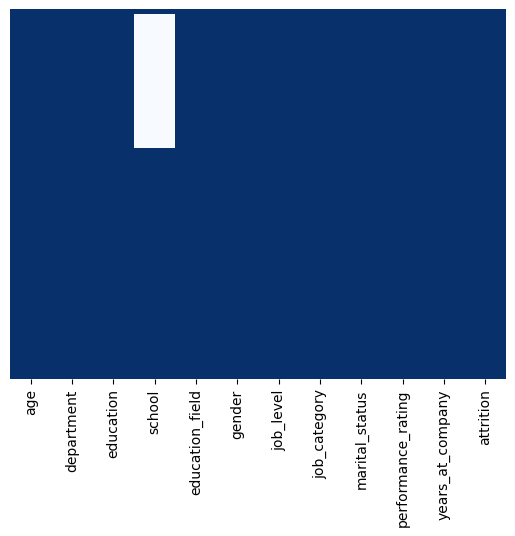

In [188]:
sns.heatmap(df.isnull(), cmap="Blues_r", cbar=False, yticklabels=False)

# 3. Data cleaning

In [189]:
cleaned_df = pd.get_dummies(df, columns=NO_ORDER_CATEGORICAL_FEATURES)
cleaned_df

,age,education,job_level,performance_rating,years_at_company,attrition,department_AIC,department_CEP,department_DES,department_DPS,...,job_category_Manager,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,30,3,4,3,3.169863,Yes,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,28,3,3,3,6.049315,Yes,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,30,3,4,4,4.254795,Yes,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,28,3,3,3,3.835616,Yes,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,27,3,3,3,3.002740,Yes,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,31,3,3,3,0.041096,No,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
4996,35,3,1,3,0.942466,No,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
4997,25,3,1,3,1.372603,No,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4998,25,3,2,3,1.191781,No,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False


### 3.1 Data cleaning

In [190]:
# One hot encoding
cleaned_df = pd.get_dummies(df, columns=NO_ORDER_CATEGORICAL_FEATURES)

# Convert all boolean to integer
for col in cleaned_df.columns:
    if cleaned_df[col].dtype == np.bool_:
        cleaned_df[col] = cleaned_df[col].astype(int)

# Convert output
cleaned_df["attrition"] = cleaned_df["attrition"].map({"Yes": 1, "No": 0})

# Move output column to the last position
attrition_column = cleaned_df.pop("attrition")
cleaned_df = pd.concat([cleaned_df, attrition_column], axis=1)

cleaned_df

,age,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,...,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,attrition
0,30,3,4,3,3.169863,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,28,3,3,3,6.049315,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,30,3,4,4,4.254795,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,28,3,3,3,3.835616,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,27,3,3,3,3.002740,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,31,3,3,3,0.041096,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4996,35,3,1,3,0.942466,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4997,25,3,1,3,1.372603,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4998,25,3,2,3,1.191781,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


### 3.2 Data standardization

In [191]:
cleaned_df

,age,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,...,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,attrition
0,30,3,4,3,3.169863,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,28,3,3,3,6.049315,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,30,3,4,4,4.254795,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,28,3,3,3,3.835616,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,27,3,3,3,3.002740,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,31,3,3,3,0.041096,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4996,35,3,1,3,0.942466,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4997,25,3,1,3,1.372603,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4998,25,3,2,3,1.191781,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [192]:
scaler = StandardScaler()

scaled_df = cleaned_df.copy()
scaled_df[NUMERICAL_FEATURES] = scaler.fit_transform(scaled_df[NUMERICAL_FEATURES])

scaled_df

,age,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,...,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,attrition
0,0.148930,3,4,3,-0.068547,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,-0.261233,3,3,3,0.813548,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,0.148930,3,4,4,0.263812,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,-0.261233,3,3,3,0.135401,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,-0.466314,3,3,3,-0.119744,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.354012,3,3,3,-1.027018,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4996,1.174338,3,1,3,-0.750891,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4997,-0.876478,3,1,3,-0.619123,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4998,-0.876478,3,2,3,-0.674516,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


# 4. Loss function selection

In [193]:
"""
z = b + w * x

y^ = 1 / (1 + e^-z) (sigmoid link function)

cost(y^, y) = -1 * (y * log(y^) + (1 - y) * log(1 - y^))

Conclusion: cost(y^, y) = 1/N * - (y^T * log(y^) + (1 - y)^T * log(1 - y^))

"""

'\nz = b + w * x\n\ny^ = 1 / (1 + e^-z) (sigmoid link function)\n\ncost(y^, y) = -1 * (y * log(y^) + (1 - y) * log(1 - y^))\n\nConclusion: cost(y^, y) = 1/N * - (y^T * log(y^) + (1 - y)^T * log(1 - y^))\n\n'

In [194]:
"""
cost(y^, y) = 1/N * - (y * log(y^) + (y - 1) * log(1 - y^))

Let A = y * log(y^)

Let B = (y - 1) * log(1 - y^)


Find dA/dw

dA/dw 
= d(y * log(y^)) / dw
= y * 1 / y^ * (dy^/dw)
= y * 1 / y^ * (dy^/dz * dz/dw)
= y * 1 / y^ * ((1 - y^) * y^ * x)
= y * (1 - y^) * x


Find dB/dw

dB/dw
= d((1 - y) * log(1 - y^)) / dw
= (1 - y) / (1 - y^) * (dy^/dw)
= (1 - y) / (1 - y^) * (dy^/dz * dz/dw)
= (1 - y) / (1 - y^) * ((1 - y^) * y^ * x)
= (1 - y) * y^ * x

=> gradient(y^, y)
= dA/dw + dB/dw
= y * (1 - y^) * x + (1 - y) * y^ * x
= x * (y^ - y)

Conclusion: gradient(y^, y) = x * (y^ - y)

"""

'\ncost(y^, y) = 1/N * - (y * log(y^) + (y - 1) * log(1 - y^))\n\nLet A = y * log(y^)\n\nLet B = (y - 1) * log(1 - y^)\n\n\nFind dA/dw\n\ndA/dw \n= d(y * log(y^)) / dw\n= y * 1 / y^ * (dy^/dw)\n= y * 1 / y^ * (dy^/dz * dz/dw)\n= y * 1 / y^ * ((1 - y^) * y^ * x)\n= y * (1 - y^) * x\n\n\nFind dB/dw\n\ndB/dw\n= d((1 - y) * log(1 - y^)) / dw\n= (1 - y) / (1 - y^) * (dy^/dw)\n= (1 - y) / (1 - y^) * (dy^/dz * dz/dw)\n= (1 - y) / (1 - y^) * ((1 - y^) * y^ * x)\n= (1 - y) * y^ * x\n\n=> gradient(y^, y)\n= dA/dw + dB/dw\n= y * (1 - y^) * x + (1 - y) * y^ * x\n= x * (y^ - y)\n\nConclusion: gradient(y^, y) = x * (y^ - y)\n\n'

# 5. Models from libraries

# 6. Algorithms optimization

### 6.1. AlgorithmType

In [195]:
class AlgorithmType(Enum):
    """Enumeration for different algorithm types with optional parameters."""

    # INCLUDED ADDITIONAL PARAMETERS

    # GRADIENT_DESCENT =================================================

    GRADIENT_DESCENT_FIX_LEARNING_RATE = {}
    """Gradient Descent with a fixed learning rate. No additional parameters."""

    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {"alpha": 1 / 4, "beta": 1 / 2}
    """Gradient Descent with backtracking line search.
    
    Parameters:
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    # STOCHASTIC_GRADIENT_DESCENT ======================================

    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE = {
        "batch_size": 1,
        "rule": 0,
        "random_seed": 10,
    }
    """Stochastic Gradient Descent with a diminishing learning rate.

    Parameters:
        batch_size: number of data points each training. Range: [0, N]. Default: 1
        rule: 0 is Randomized rule, 1 is Cyclic rule. Range: {0, 1}. Default: 0
        random_seed: Random number generator seed. Default: 10
    """

    STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE = {
        "batch_size": 1,
        "rule": 0,
        "random_seed": 10,
        "alpha": 1 / 4,
        "beta": 1 / 2,
    }
    """Stochastic Gradient Descent with a backtracking diminishing learning rate.

    Parameters:
        batch_size: number of data points each training. Range: [0, N]. Default: 1
        rule: 0 is Randomized rule, 1 is Cyclic rule. Range: {0, 1}. Default: 0
        random_seed: Random number generator seed. Default: 10
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    # MOMENTUM_GRADIENT_DESCENT ========================================

    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE = {"gamma": 0.9}
    """Momentum Gradient Descent with a fixed learning rate.

    Parameters:
        gamma: weight of previous velocity.
    """

    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {
        "gamma": 0.9,
        "alpha": 1 / 4,
        "beta": 1 / 2,
    }
    """Momentum Gradient Descent with backtracking line search.

    Parameters:
        gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    # NESTEROV_GRADIENT_DESCENT ========================================

    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE = {"NAG_gamma": 0.9}
    """Nesterov Gradient Descent with a fixed learning rate.

    Parameters:
        NAG_gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
    """

    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {
        "NAG_gamma": 0.9,
        "alpha": 1 / 4,
        "beta": 1 / 2,
    }
    """Nesterov Gradient Descent with backtracking line search.

    Parameters:
        NAG_gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    NEWTON = {"test": 1}
    """Newton algorithm
    
    Parameters:
        test: to distinguish with GRADIENT_DESCENT_FIX_LEARNING_RATE
    """

### 6.2. Result and ResultSet

In [196]:
class Result:
    def __init__(
        self,
        algorithm_type: AlgorithmType,
        patience: int,
        initial_w: np.ndarray,
        max_epochs: int,
        additional_parameters: dict,
        w_solution: np.ndarray,
        runtime: float,
        best_loss_value: float,
        epoch_count: int,
        best_f1_val: float,
        epoch_list: list,
        time_each_epoch_list: list,
        loss_value_epoch_list: list,
        initial_learning_rate: float = None,
    ):
        self.algorithm_type = algorithm_type.name
        self.patience = patience
        self.initial_w = [w[0] for w in initial_w]
        self.initial_learning_rate = initial_learning_rate
        self.max_epochs = max_epochs
        self.additional_parameters = additional_parameters
        self.w_solution = [w[0] for w in w_solution]
        self.runtime = runtime
        self.best_loss_value = self.convert_for_json(best_loss_value)
        self.epoch_count = epoch_count - 1
        self.best_f1_val = self.convert_for_json(best_f1_val)
        self.epoch_list = epoch_list
        self.time_each_epoch_list = time_each_epoch_list
        self.loss_value_epoch_list = [
            item
            for loss in loss_value_epoch_list
            for item in self.convert_for_json(loss)
        ]

    def convert_for_json(self, data):
        if isinstance(data, np.ndarray):
            # Flatten numpy arrays to a single list
            return [
                item
                for sublist in data.tolist()
                for item in (sublist if isinstance(sublist, list) else [sublist])
            ]
        elif isinstance(data, np.float64):
            # Convert np.float64 to float
            return float(data)
        elif isinstance(data, dict):
            # Recursively apply conversion to dictionary values
            return {k: self.convert_for_json(v) for k, v in data.items()}
        elif isinstance(data, list):
            # Recursively apply conversion to list elements
            return [self.convert_for_json(i) for i in data]
        else:
            # Return the data as-is
            return data


class ResultSet:
    def __init__(self):
        self.list_result: list[Result] = []

    def add_result(self, result: Result):
        if not result:
            raise Exception("Adding a None result is not allowed")

        self.list_result.append(result)

    def get_next_filename(self, base_name="result_set", extension=".json"):
        version = 1
        while True:
            if version == 1:
                filename = f"{base_name}{extension}"
            else:
                filename = f"{base_name}_{version}{extension}"

            if not os.path.exists(filename):
                return filename
            version += 1

    def output_to_json(self, file_name: str, list_result: list[Result] = None):
        invalid_chars = '<>:"/\\|?*'
        if (
            not file_name
            or len(file_name) == 0
            or any(char in invalid_chars for char in file_name)
        ):
            raise Exception("File name is invalid!")

        output_list = []

        if not list_result:
            list_result = self.list_result

        # Iterate over all results in the list_result
        for result in list_result:
            # Append each result's fields as a dictionary
            output_list.append(
                {
                    "id": len(output_list) + 1,
                    "algorithm_type": result.algorithm_type,
                    "patience": result.patience,
                    "initial_w": result.initial_w,
                    "initial_learning_rate": result.initial_learning_rate,
                    "max_epochs": result.max_epochs,
                    "additional_parameters": result.additional_parameters,
                    "w_solution": result.w_solution,
                    "runtime": result.runtime,
                    "best_loss_value": result.best_loss_value,
                    "epoch_count": result.epoch_count,
                    "best_f1_val": result.best_f1_val,
                    "epoch_list": result.epoch_list,
                    "time_each_epoch_list": result.time_each_epoch_list,
                    "loss_value_epoch_list": result.loss_value_epoch_list,
                }
            )

        # Check if file_name already existed
        file_name = self.get_next_filename()

        # Write the list of results to the JSON file
        with open(file_name, "w") as json_file:
            json.dump(output_list, json_file, indent=4)

    def load_result_from_json_in_folder(self, folder_path: str):
        if not folder_path or len(folder_path) == 0:
            raise Exception("Folder path is invalid")

        if not os.path.isdir(folder_path):
            raise Exception("Folder does not exist")

        loaded_list_result = []

        for filename in os.listdir(folder_path):
            if filename.endswith(".json"):
                file_path = os.path.join(folder_path, filename)

                # Open and load the content of the JSON file
                with open(file_path, "r") as file:
                    data = json.load(file)
                    loaded_list_result.extend(data)  # Add the content to the list

        print(f"Loaded {len(loaded_list_result)} results in all .json files")

        return loaded_list_result

    def filter_best_loss_value_result(
        self,
        list_result: list[Result],
        number_of_result: int = 1,
        algorithm_type: AlgorithmType = None,
    ):
        output = []
        if not list_result or len(list_result) == 0:
            output = []

        if number_of_result <= 0 or number_of_result != int(number_of_result):
            print(f"Invalid {number_of_result}. Set to 1")
            number_of_result = 1

        # Select best of all result
        if not algorithm_type:
            grouped_results = defaultdict(list)
            for result in list_result:
                grouped_results[result["algorithm_type"]].append(result)

            output = [
                min(result, key=lambda obj: obj["best_loss_value"][0])
                for name, result in grouped_results.items()
            ][:number_of_result]

        # Select best of algorithm_type result
        elif algorithm_type:
            output = sorted(
                [
                    obj
                    for obj in list_result
                    if obj["algorithm_type"] == algorithm_type.name
                ],
                key=lambda obj: obj["best_loss_value"][0],
                reverse=True,
            )[:number_of_result]

        print(f"Filtered and get {len(output)} results")

        return output

### 6.3. Visualizer

In [197]:
class Visualizer:
    def __init__(self):
        pass

    def plot_single_graph(
        self,
        result: Result,
        x_range: tuple[float, float] = None,
        y_range: tuple[float, float] = None,
    ):
        # Loss value according epochs
        plt.plot(result.epoch_list, result.loss_value_epoch_list)
        plt.xlabel("Epoches")
        plt.ylabel("Loss value on validation dataset")
        plt.title(
            f"Loss value on validation dataset according epochs | {result.algorithm_type}"
        )
        plt.show()

        # Loss value according time
        plt.plot(result.time_each_epoch_list, result.loss_value_epoch_list)
        plt.xlabel("Time (s)")
        plt.ylabel("Loss value on validation dataset")
        plt.title(
            f"Loss value on validation dataset according time | {result.algorithm_type}"
        )
        plt.show()

    def plot_multiple_graph(
        self,
        list_result: list[Result],
        label: str = None,
        x_range: list[float, float] = None,
        y_range: list[float, float] = None,
    ):
        # Loss value according epochs
        for result in list_result:
            if label:
                plt.plot(
                    result["epoch_list"],
                    result["loss_value_epoch_list"],
                    label=f"{label}: {result[label]}",
                )
            else:
                plt.plot(result["epoch_list"], result["loss_value_epoch_list"])

        plt.xlabel("Epoches")
        plt.ylabel("Loss value on validation dataset")
        plt.ylim(y_range)
        plt.legend()
        plt.title(f"Loss value on validation dataset according epochs")
        plt.show()

        # Loss value according time

    def summarize_a_result(self, new_result: Result):
        print(f"Parameters")
        print(f"Algorithm type: {new_result.algorithm_type}")
        if new_result.initial_learning_rate:
            print(f"Initial learning rate: {new_result.initial_learning_rate}")
        print(f"Max epochs: {new_result.max_epochs}")
        print(f"Additional parameters: {new_result.additional_parameters}")

        if new_result.epoch_count > new_result.patience:
            new_result.epoch_count -= new_result.patience

        print(f"Result")
        print(
            f"Best loss value on validation dataset at epoch {new_result.epoch_count}: {new_result.best_loss_value[0]:.6f}"
        )
        print(f"Epoch count: {new_result.epoch_count}/{new_result.max_epochs}")
        print(
            f"Best F1 on validation dataset at epoch {new_result.epoch_count}: {new_result.best_f1_val:.6f}"
        )
        print(f"Runtime: {new_result.runtime:.6f} s")

        self.plot_single_graph(new_result)

### 6.4. Optimizer

In [198]:
class Optimizer:
    def __init__(
        self,
        cleaned_df: pd.DataFrame,
        output_column: str,
    ):
        np.random.seed(18)

        self.cleaned_df = cleaned_df
        self.output_column = output_column

        self.train_df: pd.DataFrame = None
        self.Xbar_train: np.ndarray = None
        self.y_train: np.array = None

        self.validation_df: pd.DataFrame = None
        self.Xbar_val: np.ndarray = None
        self.y_val: np.array = None

        self.max_patience: int = 1000

        self.split_train_validation_dataframe()

        self.create_Xbar_and_y_from_train_dataframe()

        self.create_Xbar_and_y_from_validation_dataframe()

        self.w0 = np.random.normal(0, 1, (self.Xbar_train.shape[0], 1)).reshape(-1, 1)

    def split_train_validation_dataframe(
        self, test_size: float = 0.2, random_state: int = 42
    ):
        # current_method_name = inspect.currentframe().f_code.co_name
        # print(f"\nRunning {current_method_name}()")

        self.train_df, self.validation_df = train_test_split(
            self.cleaned_df,
            test_size=test_size,
            stratify=self.cleaned_df[self.output_column],
            random_state=random_state,
        )

        # # Print train dataset shape
        # print(f"train_df shape: {self.train_df.shape}")

        # # Calculate and print the ratio of 1s in the output column for training data
        # output_ratio_train = len(
        #     self.train_df[self.train_df[self.output_column] == 1]
        # ) / len(self.train_df)
        # print(f"train_df output ratio (1s): {output_ratio_train:.2%}")

        # # Print validation dataset shape
        # print(f"validation_df shape: {self.validation_df.shape}")

        # # Calculate and print the ratio of 1s in the output column for validation data
        # output_ratio_val = len(
        #     self.validation_df[self.validation_df[self.output_column] == 1]
        # ) / len(self.validation_df)
        # print(f"validation_df output ratio (1s): {output_ratio_val:.2%}")

    def create_Xbar_and_y_from_train_dataframe(self):
        # current_method_name = inspect.currentframe().f_code.co_name
        # print(f"\nRunning {current_method_name}()")

        X_train_df = self.train_df.drop(columns=[self.output_column])
        y_train_df = self.train_df[self.output_column]

        # Build Xbar train
        X_train = np.array(X_train_df).T
        ones = np.ones((1, X_train.shape[1]))
        self.Xbar_train = np.concatenate((ones, X_train), axis=0)

        # Build y train
        self.y_train = np.array(y_train_df).reshape(-1, 1)

    def create_Xbar_and_y_from_validation_dataframe(self):
        # current_method_name = inspect.currentframe().f_code.co_name
        # print(f"\nRunning {current_method_name}()")

        X_val_df = self.validation_df.drop(columns=[self.output_column])
        y_val_df = self.validation_df[self.output_column]

        # Build Xbar val
        X_val = np.array(X_val_df).T
        ones = np.ones((1, X_val.shape[1]))
        self.Xbar_val = np.concatenate((ones, X_val), axis=0)

        # Build y val
        self.y_val = np.array(y_val_df).reshape(-1, 1)

    def sigmoid(self, x: np.ndarray):
        return scipy.special.expit(x)

    def predict(self, w: np.ndarray, Xbar: np.ndarray):
        return self.sigmoid(Xbar.T.dot(w))

    def cost(self, w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
        # w is a vector that includes the bias
        w = w.reshape(-1, 1)
        N = Xbar.shape[1]
        y_hat = self.predict(w, Xbar)
        epsilon = 1e-15

        return (
            1
            / N
            * -(
                y.T.dot(np.log(y_hat + epsilon))
                + (1 - y).T.dot(np.log(1 - y_hat + epsilon))
            )
        )

    def grad(self, w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
        # w is a vector that includes the bias
        w = w.reshape(-1, 1)
        N = Xbar.shape[1]
        y_hat = self.predict(w, Xbar)

        return Xbar.dot(y_hat - y) / N

    def grad_2(self, w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
        # w is a vector that includes the bias
        w = w.reshape(-1, 1)
        N = Xbar.shape[1]
        y_hat = self.predict(w, Xbar)
        R = np.diag(y_hat.flatten() * (1 - y_hat.flatten()))

        return Xbar.dot(R).dot(Xbar.T) / N

    def calculate_loss_value_epoch_list(self, w_epoch_list: list[np.ndarray]):
        loss_value_epoch_list = []
        for w_epoch in w_epoch_list:
            loss_value_epoch_list.append(self.cost(w_epoch, self.Xbar_val, self.y_val))

        return loss_value_epoch_list

    def output_to_json(self, file_name: str):

        self.result_set.output_to_json(file_name)

    def balance_list_with_max_patience(self, list_value: list):
        if not list_value or len(list_value) == 0:
            raise Exception("list_value is invalid")

        if len(list_value) > self.max_patience:
            return list_value[-self.max_patience]
        else:
            return list_value[-1]

    def gradient_descent_fix_learning_rate(
        self,
        initial_learning_rate: float,
        max_epochs: int,
        additional_parameters: dict = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE.value,
    ):
        # w0 is a vector that included the bias
        w0 = self.w0

        w_epoch_list = [w0]
        epoch_list = [1]
        time_each_epoch_list = [0]
        loss_value_epoch_list = []

        best_f1_score = 0
        patience_counter = 0

        start_time = time.time()

        for epoch in range(max_epochs):

            # Update w_new
            w_new = w_epoch_list[-1] - initial_learning_rate * self.grad(
                w_epoch_list[-1], self.Xbar_train, self.y_train
            )

            # Calculate y_pred for val_df
            y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
            y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

            # Calculate F1-score
            f1_score_val = f1_score(self.y_val, y_pred_val_binary)

            # Check early stopping condition
            if f1_score_val > best_f1_score:
                best_f1_score = f1_score_val
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.max_patience:
                break

            # Post processing
            w_epoch_list.append(w_new)
            epoch_list.append(epoch_list[-1] + 1)
            time_each_epoch_list.append(time.time() - start_time)

        end_time = time.time()

        # Post calculation
        loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

        w_solution = self.balance_list_with_max_patience(w_epoch_list)
        best_loss_value = self.balance_list_with_max_patience(loss_value_epoch_list)

        # Create result
        new_result = Result(
            algorithm_type=AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE,
            patience=self.max_patience,
            initial_w=w0,
            initial_learning_rate=initial_learning_rate,
            max_epochs=max_epochs,
            additional_parameters=additional_parameters.copy(),
            w_solution=w_solution,
            runtime=end_time - start_time,
            best_loss_value=best_loss_value,
            epoch_count=epoch_list[-1],
            best_f1_val=best_f1_score,
            epoch_list=epoch_list,
            time_each_epoch_list=time_each_epoch_list,
            loss_value_epoch_list=loss_value_epoch_list,
        )

        return new_result

    def gradient_descent_backtracking_learning_rate(
        self,
        initial_learning_rate: float,
        max_epochs: int,
        additional_parameters: dict = AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
    ):
        alpha = additional_parameters["alpha"]
        beta = additional_parameters["beta"]

        # w0 is a vector that included the bias
        w0 = w0 = self.w0

        w_epoch_list = [w0]
        epoch_list = [1]
        time_each_epoch_list = [0]
        loss_value_epoch_list = []

        best_f1_score = 0
        patience_counter = 0

        start_time = time.time()

        for epoch in range(max_epochs):

            # BACKTRACKING =================================================

            learning_rate = initial_learning_rate

            # At each iteration, start with lr = lr_init, and while
            #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||grad(x)||_2^2 (squared of 2-norm)
            #           => t = beta * t
            # else
            # perform gradient descent update
            #           w_new = last_w - lr * grad(x)

            last_w = w_epoch_list[-1]
            left_hand_side = self.cost(
                last_w
                - learning_rate * self.grad(last_w, self.Xbar_train, self.y_train),
                self.Xbar_train,
                self.y_train,
            )
            right_hand_side = self.cost(
                last_w, self.Xbar_train, self.y_train
            ) - alpha * learning_rate * np.linalg.norm(
                self.grad(last_w, self.Xbar_train, self.y_train)
            )

            while left_hand_side > right_hand_side:
                # Update learning rate
                learning_rate = beta * learning_rate

                left_hand_side = self.cost(
                    last_w
                    - learning_rate * self.grad(last_w, self.Xbar_train, self.y_train),
                    self.Xbar_train,
                    self.y_train,
                )
                right_hand_side = self.cost(
                    last_w, self.Xbar_train, self.y_train
                ) - alpha * learning_rate * np.linalg.norm(
                    self.grad(last_w, self.Xbar_train, self.y_train)
                )

            # ==============================================================

            # Update w_new
            w_new = w_epoch_list[-1] - learning_rate * self.grad(
                w_epoch_list[-1], self.Xbar_train, self.y_train
            )

            # Calculate y_pred for val_df
            y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
            y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

            # Calculate F1-score
            f1_score_val = f1_score(self.y_val, y_pred_val_binary)

            # Check early stopping condition
            if f1_score_val > best_f1_score:
                best_f1_score = f1_score_val
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.max_patience:
                break

            # Post processing
            w_epoch_list.append(w_new)
            epoch_list.append(epoch_list[-1] + 1)
            time_each_epoch_list.append(time.time() - start_time)

        end_time = time.time()

        # Post calculation
        loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

        w_solution = self.balance_list_with_max_patience(w_epoch_list)
        best_loss_value = self.balance_list_with_max_patience(loss_value_epoch_list)

        # Create result
        new_result = Result(
            algorithm_type=AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,
            patience=self.max_patience,
            initial_w=w0,
            initial_learning_rate=initial_learning_rate,
            max_epochs=max_epochs,
            additional_parameters=additional_parameters.copy(),
            w_solution=w_solution,
            runtime=end_time - start_time,
            best_loss_value=best_loss_value,
            epoch_count=epoch_list[-1],
            best_f1_val=best_f1_score,
            epoch_list=epoch_list,
            time_each_epoch_list=time_each_epoch_list,
            loss_value_epoch_list=loss_value_epoch_list,
        )

        return new_result

    def stochastic_gradient_descent_diminishing_learning_rate(
        self,
        initial_learning_rate: float,
        max_epochs: int,
        additional_parameters: dict = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE.value,
    ):
        batch_size = (
            additional_parameters["batch_size"]
            if additional_parameters["batch_size"] > 0
            else 1
        )
        rule = (
            additional_parameters["rule"]
            if additional_parameters["rule"] in [0, 1]
            else 0
        )
        random_seed = additional_parameters["random_seed"]

        random.seed(random_seed)

        # Randomized rule
        if rule == 0:

            # w0 is a vector that included the bias
            w0 = self.w0

            w_epoch_list = [w0]
            epoch_list = [1]
            time_each_epoch_list = [0]
            loss_value_epoch_list = []

            best_f1_score = 0
            patience_counter = 0

            start_time = time.time()

            for epoch in range(max_epochs):
                all_indexes = list(range(self.Xbar_train.shape[1]))
                selected_indexes = []
                iteration = 0
                w_each_iteration = [w_epoch_list[-1]]

                # Update w_new
                while len(all_indexes) > 0:
                    iteration += 1

                    if batch_size < len(all_indexes):
                        selected_indexes = random.sample(all_indexes, batch_size)
                    else:
                        selected_indexes = all_indexes.copy()

                    for index in selected_indexes:
                        all_indexes.remove(index)

                    Xbar_batch = self.Xbar_train[:, selected_indexes]
                    y_batch = self.y_train[selected_indexes]

                    w_new = w_each_iteration[
                        -1
                    ] - initial_learning_rate / iteration * self.grad(
                        w_each_iteration[-1], Xbar_batch, y_batch
                    )

                    w_each_iteration.append(w_new)

                # Calculate y_pred for val_df
                y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
                y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

                # Calculate F1-score
                f1_score_val = f1_score(self.y_val, y_pred_val_binary)

                # Check early stopping condition
                if f1_score_val > best_f1_score:
                    best_f1_score = f1_score_val
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.max_patience:
                    break

                # Post processing
                w_epoch_list.append(w_each_iteration[-1])
                epoch_list.append(epoch_list[-1] + 1)
                time_each_epoch_list.append(time.time() - start_time)

            end_time = time.time()

            # Post calculation
            loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

            w_solution = self.balance_list_with_max_patience(w_epoch_list)
            best_loss_value = self.balance_list_with_max_patience(loss_value_epoch_list)

            # Create result
            new_result = Result(
                algorithm_type=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE,
                patience=self.max_patience,
                initial_w=w0,
                initial_learning_rate=initial_learning_rate,
                max_epochs=max_epochs,
                additional_parameters=additional_parameters.copy(),
                w_solution=w_solution,
                runtime=end_time - start_time,
                best_loss_value=best_loss_value,
                epoch_count=epoch_list[-1],
                best_f1_val=best_f1_score,
                epoch_list=epoch_list,
                time_each_epoch_list=time_each_epoch_list,
                loss_value_epoch_list=loss_value_epoch_list,
            )

            return new_result

        # Cyclic rule
        elif rule == 1:

            # w0 is a vector that included the bias
            w0 = self.w0

            w_epoch_list = [w0]
            epoch_list = [1]
            time_each_epoch_list = [0]
            loss_value_epoch_list = []

            best_f1_score = 0
            patience_counter = 0

            original_all_indexes = list(range(self.Xbar_train.shape[1]))
            random.shuffle(original_all_indexes)

            start_time = time.time()

            for epoch in range(max_epochs):
                all_indexes = original_all_indexes.copy()
                selected_indexes = []
                iteration = 0
                w_each_iteration = [w_epoch_list[-1]]

                # Update w_new
                while len(all_indexes) > 0:
                    iteration += 1

                    if batch_size < len(all_indexes):
                        selected_indexes = all_indexes[:batch_size]
                    else:
                        selected_indexes = all_indexes.copy()

                    for index in selected_indexes:
                        all_indexes.remove(index)

                    Xbar_batch = self.Xbar_train[:, selected_indexes]
                    y_batch = self.y_train[selected_indexes]

                    w_new = w_each_iteration[
                        -1
                    ] - initial_learning_rate / iteration * self.grad(
                        w_each_iteration[-1], Xbar_batch, y_batch
                    )

                    w_each_iteration.append(w_new)

                # Calculate y_pred for val_df
                y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
                y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

                # Calculate F1-score
                f1_score_val = f1_score(self.y_val, y_pred_val_binary)

                # Check early stopping condition
                if f1_score_val > best_f1_score:
                    best_f1_score = f1_score_val
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.max_patience:
                    break

                # Post processing
                w_epoch_list.append(w_each_iteration[-1])
                epoch_list.append(epoch_list[-1] + 1)
                time_each_epoch_list.append(time.time() - start_time)

            end_time = time.time()

            # Post calculation
            loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

            w_solution = self.balance_list_with_max_patience(w_epoch_list)
            best_loss_value = self.balance_list_with_max_patience(loss_value_epoch_list)

            # Create result
            new_result = Result(
                algorithm_type=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE,
                patience=self.max_patience,
                initial_w=w0,
                initial_learning_rate=initial_learning_rate,
                max_epochs=max_epochs,
                additional_parameters=additional_parameters.copy(),
                w_solution=w_solution,
                runtime=end_time - start_time,
                best_loss_value=best_loss_value,
                epoch_count=epoch_list[-1],
                best_f1_val=best_f1_score,
                epoch_list=epoch_list,
                time_each_epoch_list=time_each_epoch_list,
                loss_value_epoch_list=loss_value_epoch_list,
            )

            return new_result

    def stochastic_gradient_descent_backtracking_diminishing_learning_rate(
        self,
        initial_learning_rate: float,
        max_epochs: int,
        additional_parameters: dict = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE.value,
    ):
        batch_size = (
            additional_parameters["batch_size"]
            if additional_parameters["batch_size"] > 0
            else 1
        )
        rule = (
            additional_parameters["rule"]
            if additional_parameters["rule"] in [0, 1]
            else 0
        )
        random_seed = additional_parameters["random_seed"]
        alpha = additional_parameters["alpha"]
        beta = additional_parameters["beta"]

        random.seed(random_seed)

        # Randomized rule
        if rule == 0:

            # w0 is a vector that included the bias
            w0 = self.w0

            w_epoch_list = [w0]
            epoch_list = [1]
            time_each_epoch_list = [0]
            loss_value_epoch_list = []

            best_f1_score = 0
            patience_counter = 0

            start_time = time.time()

            for epoch in range(max_epochs):
                all_indexes = list(range(self.Xbar_train.shape[1]))
                selected_indexes = []
                iteration = 0
                w_each_iteration = [w_epoch_list[-1]]

                # Update w_new
                while len(all_indexes) > 0:
                    iteration += 1

                    if batch_size < len(all_indexes):
                        selected_indexes = random.sample(all_indexes, batch_size)
                    else:
                        selected_indexes = all_indexes.copy()

                    for index in selected_indexes:
                        all_indexes.remove(index)

                    Xbar_batch = self.Xbar_train[:, selected_indexes]
                    y_batch = self.y_train[selected_indexes]

                    # BACKTRACKING =================================================

                    learning_rate = initial_learning_rate / iteration

                    # At each iteration, start with lr = lr_init, and while
                    #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||grad(x)||_2^2 (squared of 2-norm)
                    #           => t = beta * t
                    # else
                    # perform gradient descent update
                    #           w_new = last_w - lr * grad(x)

                    last_w = w_epoch_list[-1]
                    left_hand_side = self.cost(
                        last_w - learning_rate * self.grad(last_w, Xbar_batch, y_batch),
                        Xbar_batch,
                        y_batch,
                    )
                    right_hand_side = self.cost(
                        last_w, Xbar_batch, y_batch
                    ) - alpha * learning_rate * np.linalg.norm(
                        self.grad(last_w, Xbar_batch, y_batch)
                    )

                    while left_hand_side > right_hand_side:
                        # Update learning rate
                        learning_rate = beta * learning_rate

                        left_hand_side = self.cost(
                            last_w
                            - learning_rate * self.grad(last_w, Xbar_batch, y_batch),
                            Xbar_batch,
                            y_batch,
                        )
                        right_hand_side = self.cost(
                            last_w, Xbar_batch, y_batch
                        ) - alpha * learning_rate * np.linalg.norm(
                            self.grad(last_w, Xbar_batch, y_batch)
                        )

                    # ==============================================================

                    # Update w_new
                    w_new = w_epoch_list[-1] - learning_rate * self.grad(
                        w_epoch_list[-1], Xbar_batch, y_batch
                    )

                    w_each_iteration.append(w_new)

                # Calculate y_pred for val_df
                y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
                y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

                # Calculate F1-score
                f1_score_val = f1_score(self.y_val, y_pred_val_binary)

                # Check early stopping condition
                if f1_score_val > best_f1_score:
                    best_f1_score = f1_score_val
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.max_patience:
                    break

                # Post processing
                w_epoch_list.append(w_each_iteration[-1])
                epoch_list.append(epoch_list[-1] + 1)
                time_each_epoch_list.append(time.time() - start_time)

            end_time = time.time()

            # Post calculation
            loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

            w_solution = self.balance_list_with_max_patience(w_epoch_list)
            best_loss_value = self.balance_list_with_max_patience(loss_value_epoch_list)

            # Create result
            new_result = Result(
                algorithm_type=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE,
                patience=self.max_patience,
                initial_w=w0,
                initial_learning_rate=initial_learning_rate,
                max_epochs=max_epochs,
                additional_parameters=additional_parameters.copy(),
                w_solution=w_solution,
                runtime=end_time - start_time,
                best_loss_value=best_loss_value,
                epoch_count=epoch_list[-1],
                best_f1_val=best_f1_score,
                epoch_list=epoch_list,
                time_each_epoch_list=time_each_epoch_list,
                loss_value_epoch_list=loss_value_epoch_list,
            )

            return new_result

        # Cyclic rule
        elif rule == 1:

            # w0 is a vector that included the bias
            w0 = self.w0

            w_epoch_list = [w0]
            epoch_list = [1]
            time_each_epoch_list = [0]
            loss_value_epoch_list = []

            best_f1_score = 0
            patience_counter = 0

            original_all_indexes = list(range(self.Xbar_train.shape[1]))
            random.shuffle(original_all_indexes)

            start_time = time.time()

            for epoch in range(max_epochs):
                all_indexes = original_all_indexes.copy()
                selected_indexes = []
                iteration = 0
                w_each_iteration = [w_epoch_list[-1]]

                # Update w_new
                while len(all_indexes) > 0:
                    iteration += 1

                    if batch_size < len(all_indexes):
                        selected_indexes = all_indexes[:batch_size]
                    else:
                        selected_indexes = all_indexes.copy()

                    for index in selected_indexes:
                        all_indexes.remove(index)

                    Xbar_batch = self.Xbar_train[:, selected_indexes]
                    y_batch = self.y_train[selected_indexes]

                    # BACKTRACKING =================================================

                    learning_rate = initial_learning_rate / iteration

                    # At each iteration, start with lr = lr_init, and while
                    #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||grad(x)||_2^2 (squared of 2-norm)
                    #           => t = beta * t
                    # else
                    # perform gradient descent update
                    #           w_new = last_w - lr * grad(x)

                    last_w = w_epoch_list[-1]
                    left_hand_side = self.cost(
                        last_w - learning_rate * self.grad(last_w, Xbar_batch, y_batch),
                        Xbar_batch,
                        y_batch,
                    )
                    right_hand_side = self.cost(
                        last_w, Xbar_batch, y_batch
                    ) - alpha * learning_rate * np.linalg.norm(
                        self.grad(last_w, Xbar_batch, y_batch)
                    )

                    while left_hand_side > right_hand_side:
                        # Update learning rate
                        learning_rate = beta * learning_rate

                        left_hand_side = self.cost(
                            last_w
                            - learning_rate * self.grad(last_w, Xbar_batch, y_batch),
                            Xbar_batch,
                            y_batch,
                        )
                        right_hand_side = self.cost(
                            last_w, Xbar_batch, y_batch
                        ) - alpha * learning_rate * np.linalg.norm(
                            self.grad(last_w, Xbar_batch, y_batch)
                        )

                    # ==============================================================

                    # Update w_new
                    w_new = w_epoch_list[-1] - learning_rate * self.grad(
                        w_epoch_list[-1], Xbar_batch, y_batch
                    )

                    w_each_iteration.append(w_new)

                # Calculate y_pred for val_df
                y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
                y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

                # Calculate F1-score
                f1_score_val = f1_score(self.y_val, y_pred_val_binary)

                # Check early stopping condition
                if f1_score_val > best_f1_score:
                    best_f1_score = f1_score_val
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.max_patience:
                    break

                # Post processing
                w_epoch_list.append(w_each_iteration[-1])
                epoch_list.append(epoch_list[-1] + 1)
                time_each_epoch_list.append(time.time() - start_time)

            end_time = time.time()

            # Post calculation
            loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

            w_solution = self.balance_list_with_max_patience(w_epoch_list)
            best_loss_value = self.balance_list_with_max_patience(loss_value_epoch_list)

            # Create result
            new_result = Result(
                algorithm_type=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE,
                patience=self.max_patience,
                initial_w=w0,
                initial_learning_rate=initial_learning_rate,
                max_epochs=max_epochs,
                additional_parameters=additional_parameters.copy(),
                w_solution=w_solution,
                runtime=end_time - start_time,
                best_loss_value=best_loss_value,
                epoch_count=epoch_list[-1],
                best_f1_val=best_f1_score,
                epoch_list=epoch_list,
                time_each_epoch_list=time_each_epoch_list,
                loss_value_epoch_list=loss_value_epoch_list,
            )

            return new_result

    def momentum_gradient_descent_fix_learning_rate(
        self,
        initial_learning_rate: float,
        max_epochs: int,
        additional_parameters: dict = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE.value,
    ):
        gamma = additional_parameters["gamma"]

        # w0 is a vector that included the bias
        w0 = self.w0

        w_epoch_list = [w0]
        epoch_list = [1]
        time_each_epoch_list = [0]
        loss_value_epoch_list = []

        v_old = np.zeros_like(w0)

        best_f1_score = 0
        patience_counter = 0

        start_time = time.time()

        for epoch in range(max_epochs):

            v_new = gamma * v_old + initial_learning_rate * self.grad(
                w_epoch_list[-1], self.Xbar_train, self.y_train
            )

            # Update w_new
            w_new = w_epoch_list[-1] - v_new

            # Calculate y_pred for val_df
            y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
            y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

            # Calculate F1-score
            f1_score_val = f1_score(self.y_val, y_pred_val_binary)

            # Check early stopping condition
            if f1_score_val > best_f1_score:
                best_f1_score = f1_score_val
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.max_patience:
                break

            # Post processing
            w_epoch_list.append(w_new)
            epoch_list.append(epoch_list[-1] + 1)
            time_each_epoch_list.append(time.time() - start_time)

            v_old = v_new

        end_time = time.time()

        # Post calculation
        loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

        w_solution = self.balance_list_with_max_patience(w_epoch_list)
        best_loss_value = self.balance_list_with_max_patience(loss_value_epoch_list)

        # Create result
        new_result = Result(
            algorithm_type=AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,
            patience=self.max_patience,
            initial_w=w0,
            initial_learning_rate=initial_learning_rate,
            max_epochs=max_epochs,
            additional_parameters=additional_parameters.copy(),
            w_solution=w_solution,
            runtime=end_time - start_time,
            best_loss_value=best_loss_value,
            epoch_count=epoch_list[-1],
            best_f1_val=best_f1_score,
            epoch_list=epoch_list,
            time_each_epoch_list=time_each_epoch_list,
            loss_value_epoch_list=loss_value_epoch_list,
        )

        return new_result

    def momentum_gradient_descent_backtracking_learning_rate(
        self,
        initial_learning_rate: float,
        max_epochs: int,
        additional_parameters: dict = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
    ):
        gamma = additional_parameters["gamma"]
        alpha = additional_parameters["alpha"]
        beta = additional_parameters["beta"]

        # w0 is a vector that included the bias
        w0 = self.w0

        w_epoch_list = [w0]
        epoch_list = [1]
        time_each_epoch_list = [0]
        loss_value_epoch_list = []

        v_old = np.zeros_like(w0)

        best_f1_score = 0
        patience_counter = 0

        start_time = time.time()

        for epoch in range(max_epochs):

            # BACKTRACKING =================================================

            learning_rate = initial_learning_rate

            # At each iteration, start with lr = lr_init, and while
            #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||grad(x)||_2^2 (squared of 2-norm)
            #           => t = beta * t
            # else
            # perform gradient descent update
            #           w_new = last_w - lr * grad(x)

            last_w = w_epoch_list[-1]
            left_hand_side = self.cost(
                last_w
                - learning_rate * self.grad(last_w, self.Xbar_train, self.y_train),
                self.Xbar_train,
                self.y_train,
            )
            right_hand_side = self.cost(
                last_w, self.Xbar_train, self.y_train
            ) - alpha * learning_rate * np.linalg.norm(
                self.grad(last_w, self.Xbar_train, self.y_train)
            )

            while left_hand_side > right_hand_side:
                # Update learning rate
                learning_rate = beta * learning_rate

                left_hand_side = self.cost(
                    last_w
                    - learning_rate * self.grad(last_w, self.Xbar_train, self.y_train),
                    self.Xbar_train,
                    self.y_train,
                )
                right_hand_side = self.cost(
                    last_w, self.Xbar_train, self.y_train
                ) - alpha * learning_rate * np.linalg.norm(
                    self.grad(last_w, self.Xbar_train, self.y_train)
                )

            # ==============================================================

            v_new = gamma * v_old + learning_rate * self.grad(
                w_epoch_list[-1], self.Xbar_train, self.y_train
            )

            # Update w_new
            w_new = w_epoch_list[-1] - v_new

            # Calculate y_pred for val_df
            y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
            y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

            # Calculate F1-score
            f1_score_val = f1_score(self.y_val, y_pred_val_binary)

            # Check early stopping condition
            if f1_score_val > best_f1_score:
                best_f1_score = f1_score_val
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.max_patience:
                break

            # Post processing
            w_epoch_list.append(w_new)
            epoch_list.append(epoch_list[-1] + 1)
            time_each_epoch_list.append(time.time() - start_time)

            v_old = v_new

        end_time = time.time()

        # Post calculation
        loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

        w_solution = self.balance_list_with_max_patience(w_epoch_list)
        best_loss_value = self.balance_list_with_max_patience(loss_value_epoch_list)

        # Create result
        new_result = Result(
            algorithm_type=AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,
            patience=self.max_patience,
            initial_w=w0,
            initial_learning_rate=initial_learning_rate,
            max_epochs=max_epochs,
            additional_parameters=additional_parameters.copy(),
            w_solution=w_solution,
            runtime=end_time - start_time,
            best_loss_value=best_loss_value,
            epoch_count=epoch_list[-1],
            best_f1_val=best_f1_score,
            epoch_list=epoch_list,
            time_each_epoch_list=time_each_epoch_list,
            loss_value_epoch_list=loss_value_epoch_list,
        )

        return new_result

    def nesterov_gradient_descent_fix_learning_rate(
        self,
        initial_learning_rate: float,
        max_epochs: int,
        additional_parameters: dict = AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE.value,
    ):
        gamma = additional_parameters["NAG_gamma"]

        # w0 is a vector that included the bias
        w0 = self.w0

        w_epoch_list = [w0]
        epoch_list = [1]
        time_each_epoch_list = [0]
        loss_value_epoch_list = []

        v = [np.zeros_like(w0)]

        best_f1_score = 0
        patience_counter = 0

        start_time = time.time()

        for epoch in range(max_epochs):

            v_new = gamma * v[-1] + initial_learning_rate * self.grad(
                w_epoch_list[-1] - gamma * v[-1], self.Xbar_train, self.y_train
            )

            # Update w_new
            w_new = w_epoch_list[-1] - v_new

            # Calculate y_pred for val_df
            y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
            y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

            # Calculate F1-score
            f1_score_val = f1_score(self.y_val, y_pred_val_binary)

            # Check early stopping condition
            if f1_score_val > best_f1_score:
                best_f1_score = f1_score_val
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.max_patience:
                break

            # Post processing
            w_epoch_list.append(w_new)
            epoch_list.append(epoch_list[-1] + 1)
            time_each_epoch_list.append(time.time() - start_time)

            v.append(v_new)

        end_time = time.time()

        # Post calculation
        loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

        w_solution = self.balance_list_with_max_patience(w_epoch_list)
        best_loss_value = self.balance_list_with_max_patience(loss_value_epoch_list)

        # Create result
        new_result = Result(
            algorithm_type=AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,
            patience=self.max_patience,
            initial_w=w0,
            initial_learning_rate=initial_learning_rate,
            max_epochs=max_epochs,
            additional_parameters=additional_parameters.copy(),
            w_solution=w_solution,
            runtime=end_time - start_time,
            best_loss_value=best_loss_value,
            epoch_count=epoch_list[-1],
            best_f1_val=best_f1_score,
            epoch_list=epoch_list,
            time_each_epoch_list=time_each_epoch_list,
            loss_value_epoch_list=loss_value_epoch_list,
        )

        return new_result

    def nesterov_gradient_descent_backtracking_learning_rate(
        self,
        initial_learning_rate: float,
        max_epochs: int,
        additional_parameters: dict = AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
    ):
        gamma = additional_parameters["NAG_gamma"]
        alpha = additional_parameters["alpha"]
        beta = additional_parameters["beta"]

        # w0 is a vector that included the bias
        w0 = self.w0

        w_epoch_list = [w0]
        epoch_list = [1]
        time_each_epoch_list = [0]
        loss_value_epoch_list = []

        v = [np.zeros_like(w0)]

        best_f1_score = 0
        patience_counter = 0

        start_time = time.time()

        for epoch in range(max_epochs):

            # BACKTRACKING =================================================

            learning_rate = initial_learning_rate

            # At each iteration, start with lr = lr_init, and while
            #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||grad(x)||_2^2 (squared of 2-norm)
            #           => t = beta * t
            # else
            # perform gradient descent update
            #           w_new = last_w - lr * grad(x)

            last_w = w_epoch_list[-1]
            left_hand_side = self.cost(
                last_w
                - learning_rate * self.grad(last_w, self.Xbar_train, self.y_train),
                self.Xbar_train,
                self.y_train,
            )
            right_hand_side = self.cost(
                last_w, self.Xbar_train, self.y_train
            ) - alpha * learning_rate * np.linalg.norm(
                self.grad(last_w, self.Xbar_train, self.y_train)
            )

            while left_hand_side > right_hand_side:
                # Update learning rate
                learning_rate = beta * learning_rate

                left_hand_side = self.cost(
                    last_w
                    - learning_rate * self.grad(last_w, self.Xbar_train, self.y_train),
                    self.Xbar_train,
                    self.y_train,
                )
                right_hand_side = self.cost(
                    last_w, self.Xbar_train, self.y_train
                ) - alpha * learning_rate * np.linalg.norm(
                    self.grad(last_w, self.Xbar_train, self.y_train)
                )

            # ==============================================================

            v_new = gamma * v[-1] + learning_rate * self.grad(
                w_epoch_list[-1] - gamma * v[-1], self.Xbar_train, self.y_train
            )

            # Update w_new
            w_new = w_epoch_list[-1] - v_new

            # Calculate y_pred for val_df
            y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
            y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

            # Calculate F1-score
            f1_score_val = f1_score(self.y_val, y_pred_val_binary)

            # Check early stopping condition
            if f1_score_val > best_f1_score:
                best_f1_score = f1_score_val
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.max_patience:
                break

            # Post processing
            w_epoch_list.append(w_new)
            epoch_list.append(epoch_list[-1] + 1)
            time_each_epoch_list.append(time.time() - start_time)

            v.append(v_new)

        end_time = time.time()

        # Post calculation
        loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

        w_solution = self.balance_list_with_max_patience(w_epoch_list)
        best_loss_value = self.balance_list_with_max_patience(loss_value_epoch_list)

        # Create result
        new_result = Result(
            algorithm_type=AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,
            patience=self.max_patience,
            initial_w=w0,
            initial_learning_rate=initial_learning_rate,
            max_epochs=max_epochs,
            additional_parameters=additional_parameters.copy(),
            w_solution=w_solution,
            runtime=end_time - start_time,
            best_loss_value=best_loss_value,
            epoch_count=epoch_list[-1],
            best_f1_val=best_f1_score,
            epoch_list=epoch_list,
            time_each_epoch_list=time_each_epoch_list,
            loss_value_epoch_list=loss_value_epoch_list,
        )

        return new_result

    def newton(
        self,
        max_epochs: int,
        additional_parameters: dict = AlgorithmType.NEWTON.value,
    ):
        # w0 is a vector that included the bias
        w0 = np.zeros((self.Xbar_train.shape[0], 1)).reshape(-1, 1)
        # w0 = self.w0

        w_epoch_list = [w0]
        epoch_list = [1]
        time_each_epoch_list = [0]
        loss_value_epoch_list = []

        best_f1_score = 0
        patience_counter = 0

        start_time = time.time()

        for epoch in range(max_epochs):

            "w+ = w - (f''(w))^-1 * f'(w)"

            # Update w_new
            w_new = w_epoch_list[-1] - np.linalg.pinv(
                self.grad_2(w_epoch_list[-1], self.Xbar_train, self.y_train)
            ).dot(self.grad(w_epoch_list[-1], self.Xbar_train, self.y_train))

            # Calculate y_pred for val_df
            y_pred_val = self.predict(w_epoch_list[-1], self.Xbar_val)
            y_pred_val_binary = (y_pred_val >= 0.5).astype(int)

            # Calculate F1-score
            f1_score_val = f1_score(self.y_val, y_pred_val_binary)

            # Check early stopping condition
            if f1_score_val > best_f1_score:
                best_f1_score = f1_score_val
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.max_patience:
                break

            # Post processing
            w_epoch_list.append(w_new)
            epoch_list.append(epoch_list[-1] + 1)
            time_each_epoch_list.append(time.time() - start_time)

        end_time = time.time()

        # Post calculation
        loss_value_epoch_list = self.calculate_loss_value_epoch_list(w_epoch_list)

        best_loss_value = min(loss_value_epoch_list)
        best_index = loss_value_epoch_list.index(best_loss_value)
        w_solution = w_epoch_list[best_index]
        epoch_count = epoch_list[best_index]

        # Create result
        new_result = Result(
            algorithm_type=AlgorithmType.NEWTON,
            patience=self.max_patience,
            initial_w=w0,
            max_epochs=max_epochs,
            additional_parameters=additional_parameters.copy(),
            w_solution=w_solution,
            runtime=end_time - start_time,
            best_loss_value=best_loss_value,
            epoch_count=epoch_count,
            best_f1_val=best_f1_score,
            epoch_list=epoch_list,
            time_each_epoch_list=time_each_epoch_list,
            loss_value_epoch_list=loss_value_epoch_list,
        )

        return new_result

### 6.5. Framework initialization

In [199]:
main_optimizer = Optimizer(cleaned_df=scaled_df, output_column=OUTPUT_NAME)

In [200]:
result_set = ResultSet()

In [201]:
visualizer = Visualizer()

### START FRAWEWORK ABOVE THIS LINE

In [312]:
"""Start by running all cells above this line"""

'Start by running all cells above this line'

### 6.6. GRADIENT_DESCENT_FIX_LEARNING_RATE

Parameters
Algorithm type: GRADIENT_DESCENT_FIX_LEARNING_RATE
Initial learning rate: 0.001
Max epochs: 11000
Additional parameters: {}
Result
Best loss value on validation dataset at epoch 12: 2.498400
Epoch count: 1012/11000
Best F1 on validation dataset at epoch 12: 0.533778
Runtime: 7.139553 s


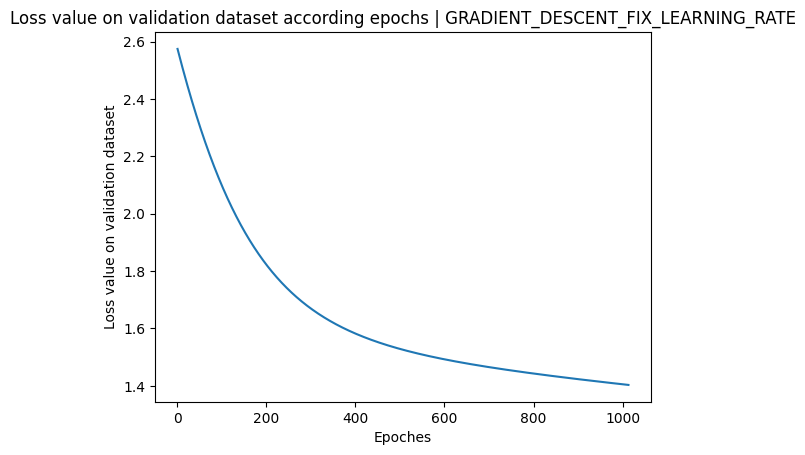

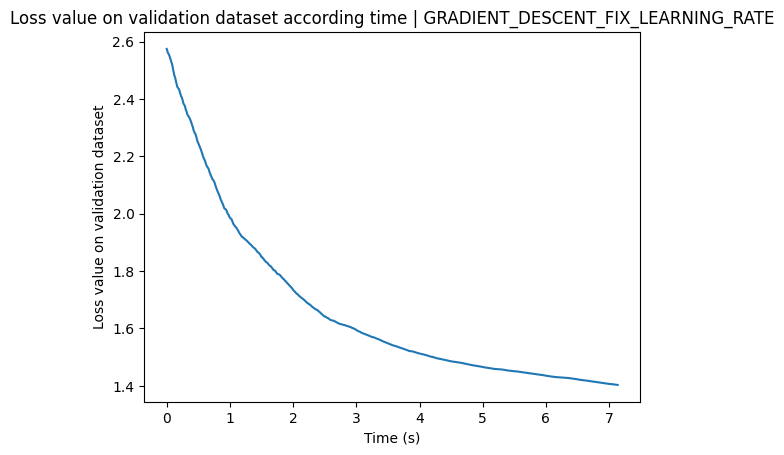

In [338]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_LEARNING_RATE = 0.001
MAX_EPOCHS = 11000  # SHOULD OVER 1000

result = main_optimizer.gradient_descent_fix_learning_rate(
    INITIAL_LEARNING_RATE, MAX_EPOCHS
)

result_set.add_result(result)

visualizer.summarize_a_result(result)

## TEST

Parameters
Algorithm type: GRADIENT_DESCENT_FIX_LEARNING_RATE
Initial learning rate: 0.3
Max epochs: 30000
Additional parameters: {}
Result
Best loss value on validation dataset: 0.188017
Epoch count: 16305/30000
Best F1 on validation dataset: 0.935780
Runtime: 53.794885 s


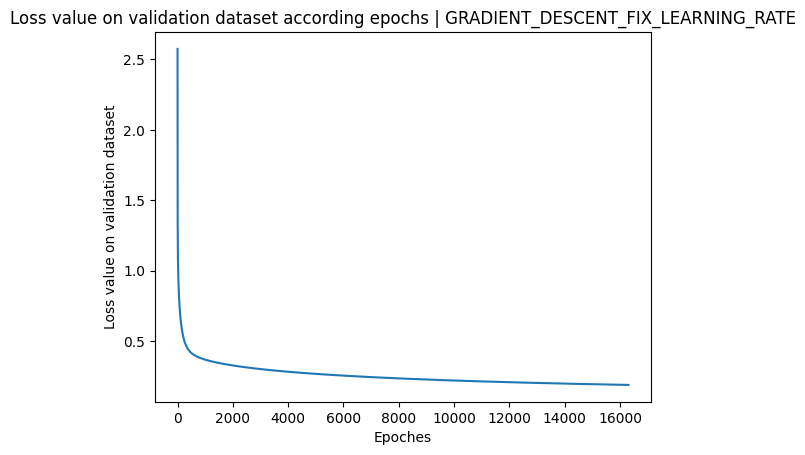

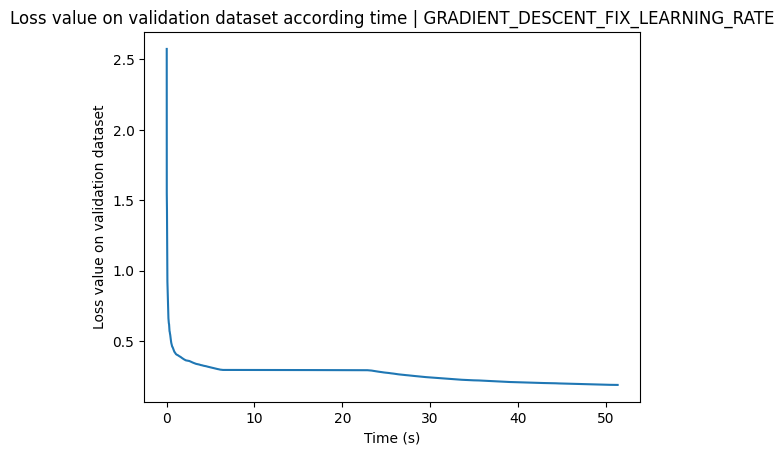

Parameters
Algorithm type: GRADIENT_DESCENT_FIX_LEARNING_RATE
Initial learning rate: 0.5
Max epochs: 30000
Additional parameters: {}
Result
Best loss value on validation dataset: 0.184213
Epoch count: 10424/30000
Best F1 on validation dataset: 0.937008
Runtime: 24.698079 s


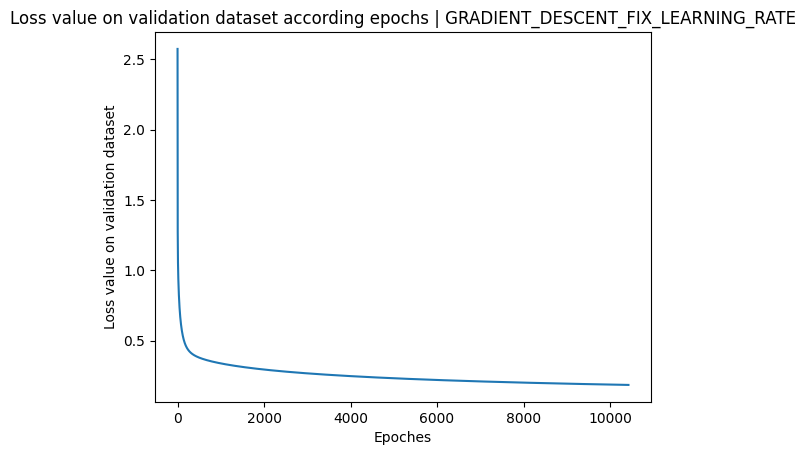

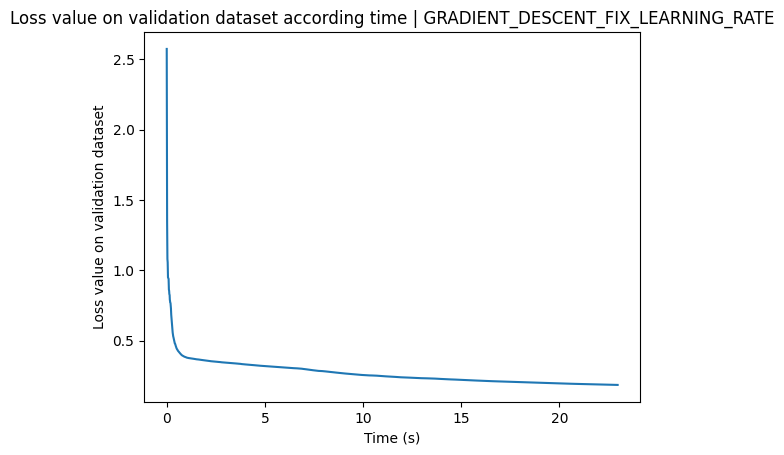

In [159]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE
# INITIAL_LEARNING_RATE = 0.3
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

for INITIAL_LEARNING_RATE in [0.3]:
    for MAX_EPOCHS in [1000]:
        result = main_optimizer.gradient_descent_fix_learning_rate(
            INITIAL_LEARNING_RATE, MAX_EPOCHS
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

## 6.7. GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

Parameters
Algorithm type: GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Initial learning rate: 1
Max epochs: 300
Additional parameters: {'alpha': 0.05, 'beta': 0.9}
Result
Best loss value: 0.511892
Epoch count: 81/300
Best F1 on validation set: 0.603723
Runtime: 146.682284 s


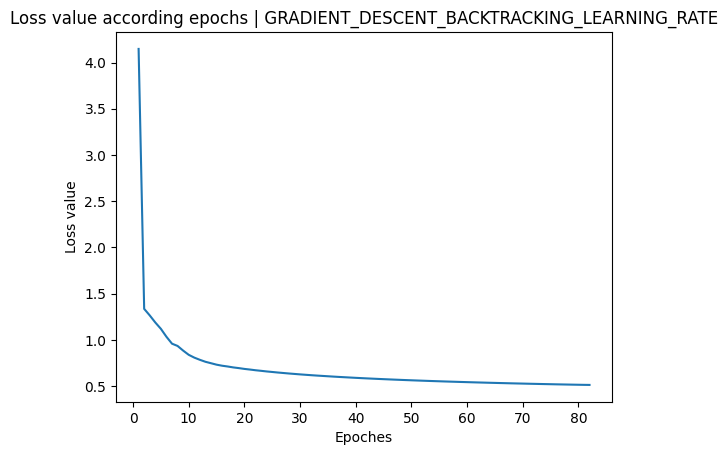

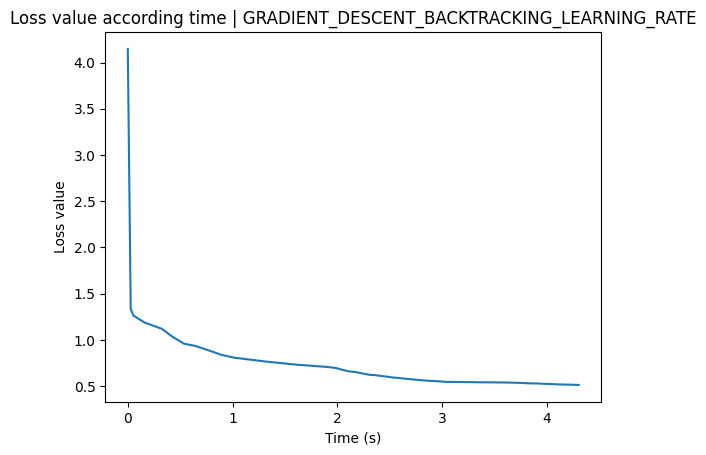

In [883]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 1100  # SHOULD OVER 1000

ALPHA = 0.05
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = main_optimizer.gradient_descent_backtracking_learning_rate(
    INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
)

result_set.add_result(result)

visualizer.summarize_a_result(result)

## TEST

In [ ]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
# INITIAL_LEARNING_RATE = 1
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

ALPHA = 0.05
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

for INITIAL_LEARNING_RATE in [0.3]:
    for MAX_EPOCHS in [300]:
        result = main_optimizer.gradient_descent_backtracking_learning_rate(
            INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

## 6.8. STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE - randomized

Parameters
Algorithm type: STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Initial learning rate: 0.3
Max epochs: 1100
Additional parameters: {'batch_size': 1, 'rule': 0, 'random_seed': 10}
Result
Best loss value on validation dataset at epoch 100: 0.383688
Epoch count: 1100/1100
Best F1 on validation dataset at epoch 100: 0.901042
Runtime: 252.075842 s


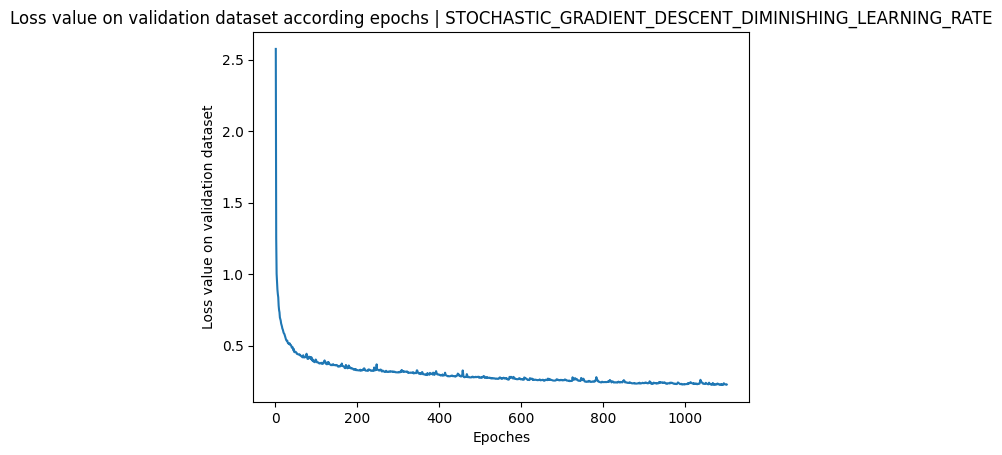

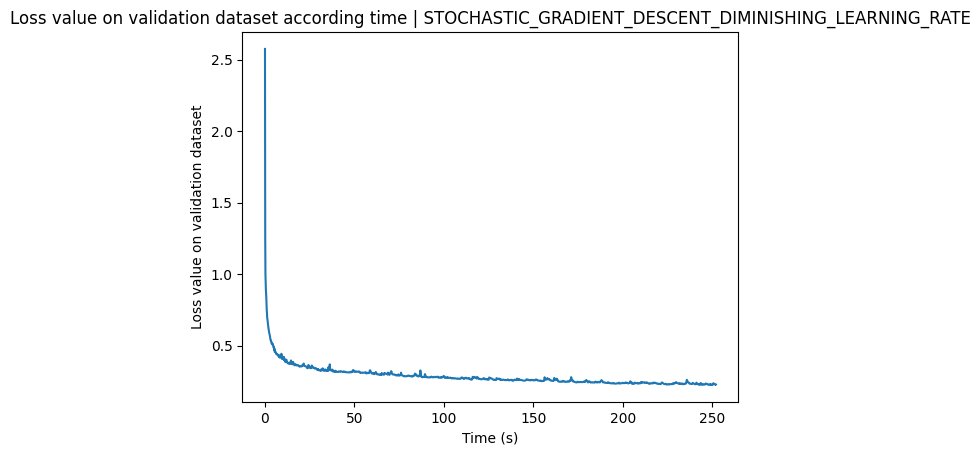

In [442]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_LEARNING_RATE = 0.3
MAX_EPOCHS = 1100  # SHOULD OVER 1000

RULE = 0  # randomized

BATCH_SIZE = 1
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

result = main_optimizer.stochastic_gradient_descent_diminishing_learning_rate(
    INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
)

result_set.add_result(result)

visualizer.summarize_a_result(result)

## TEST

In [ ]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
# INITIAL_LEARNING_RATE = 0.3
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

RULE = 0  # randomized

BATCH_SIZE = 1
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

for INITIAL_LEARNING_RATE in [0.3]:
    for MAX_EPOCHS in [300]:
        result = main_optimizer.stochastic_gradient_descent_diminishing_learning_rate(
            INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

## 6.9. STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE - cyclic

Parameters
Algorithm type: STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Initial learning rate: 0.3
Max epochs: 300
Additional parameters: {'batch_size': 1, 'rule': 1, 'random_seed': 10}
Result
Best loss value: 0.371821
Epoch count: 300/300
Best F1 on validation set: 0.749672
Runtime: 24.534436 s


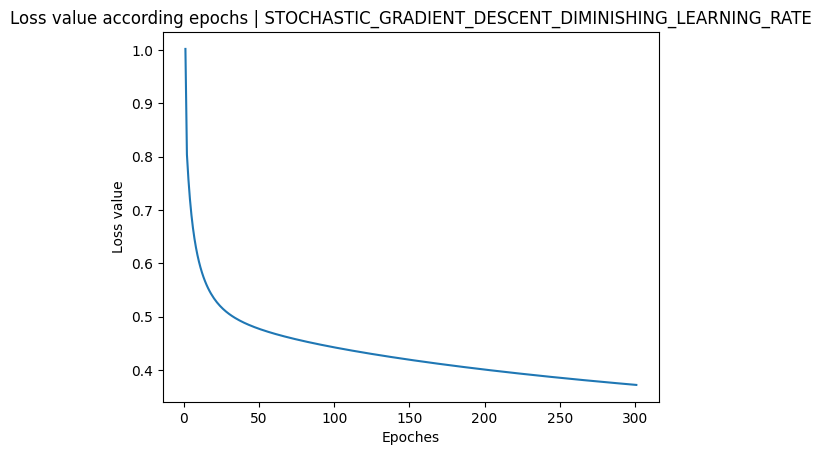

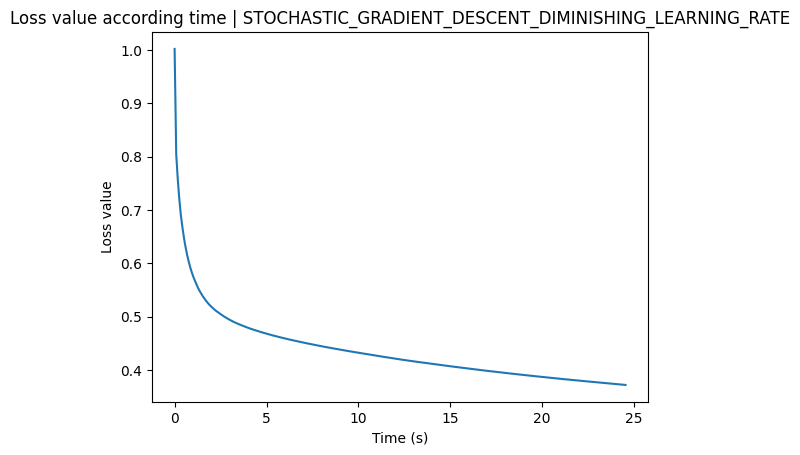

In [885]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_LEARNING_RATE = 0.3
MAX_EPOCHS = 1100  # SHOULD OVER 1000

RULE = 1  # cyclic

BATCH_SIZE = 1
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

result = main_optimizer.stochastic_gradient_descent_diminishing_learning_rate(
    INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
)

result_set.add_result(result)

visualizer.summarize_a_result(result)

## TEST

In [25]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
# INITIAL_LEARNING_RATE = 0.3
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

RULE = 1  # cyclic

BATCH_SIZE = 1
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

for INITIAL_LEARNING_RATE in [0.3]:
    for MAX_EPOCHS in [300]:
        result = main_optimizer.stochastic_gradient_descent_diminishing_learning_rate(
            INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

KeyboardInterrupt: 

Parameters
Algorithm type: STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Initial learning rate: 0.5
Max epochs: 100
Additional parameters: {'batch_size': 16, 'rule': 1, 'random_seed': 10}
Result
Best loss value on validation dataset at epoch 100: 0.400256
Epoch count: 100/100
Best F1 on validation dataset at epoch 100: 0.748353
Runtime: 3.212642 s


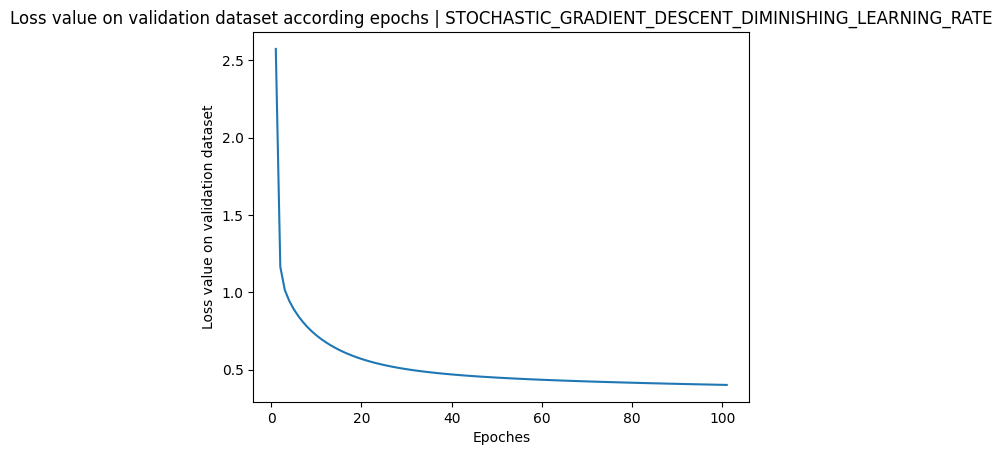

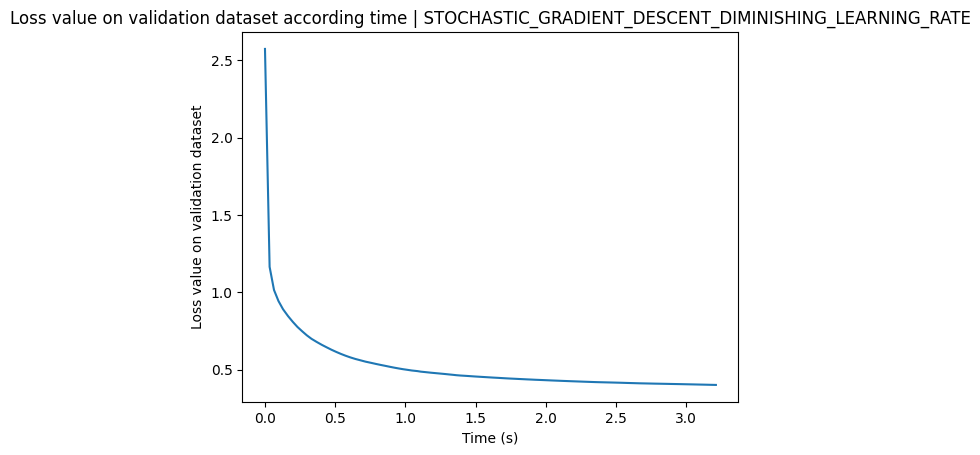

Parameters
Algorithm type: STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Initial learning rate: 0.5
Max epochs: 100
Additional parameters: {'batch_size': 32, 'rule': 1, 'random_seed': 10}
Result
Best loss value on validation dataset at epoch 100: 0.395139
Epoch count: 100/100
Best F1 on validation dataset at epoch 100: 0.756899
Runtime: 2.896612 s


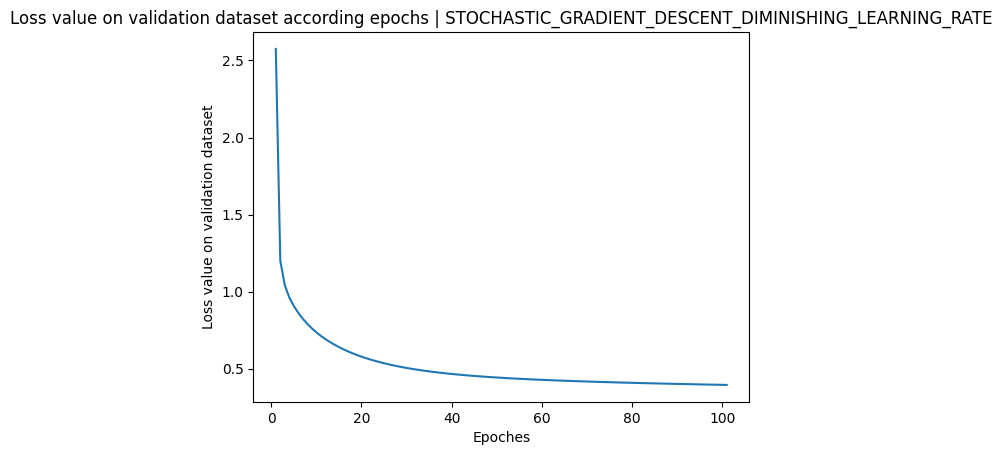

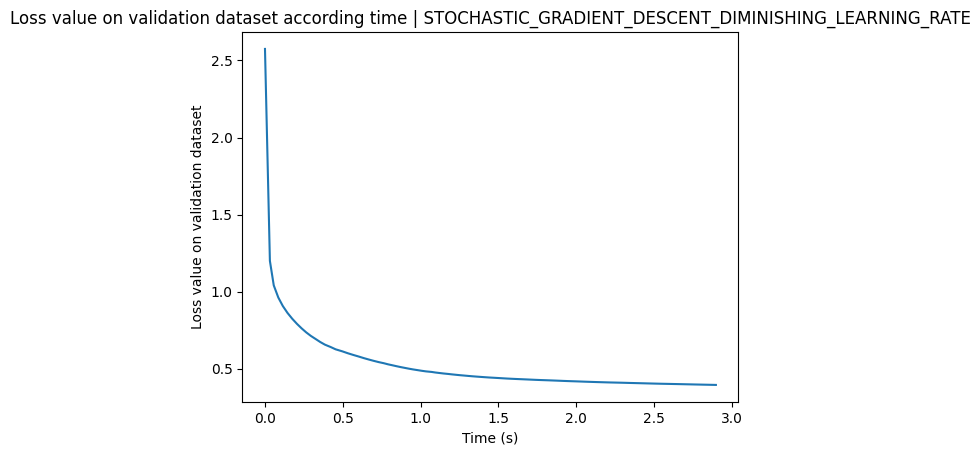

Parameters
Algorithm type: STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Initial learning rate: 0.5
Max epochs: 100
Additional parameters: {'batch_size': 64, 'rule': 1, 'random_seed': 10}
Result
Best loss value on validation dataset at epoch 100: 0.395126
Epoch count: 100/100
Best F1 on validation dataset at epoch 100: 0.768212
Runtime: 2.928511 s


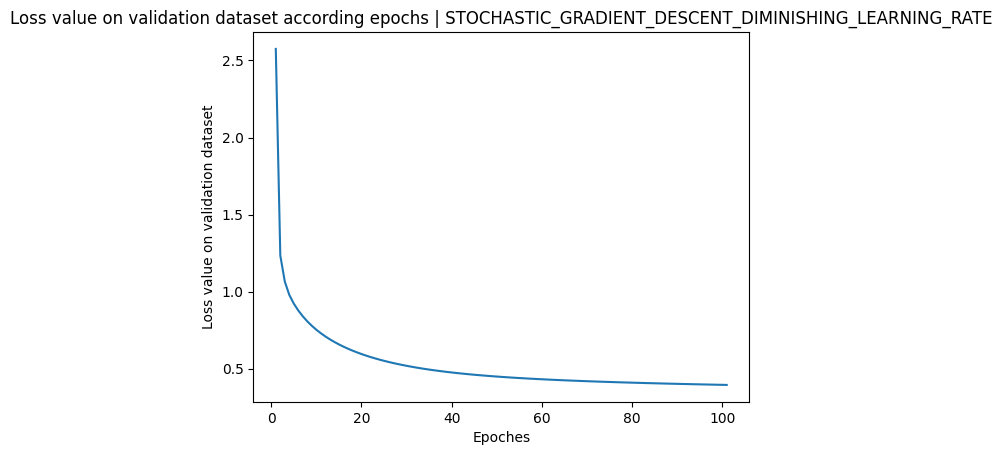

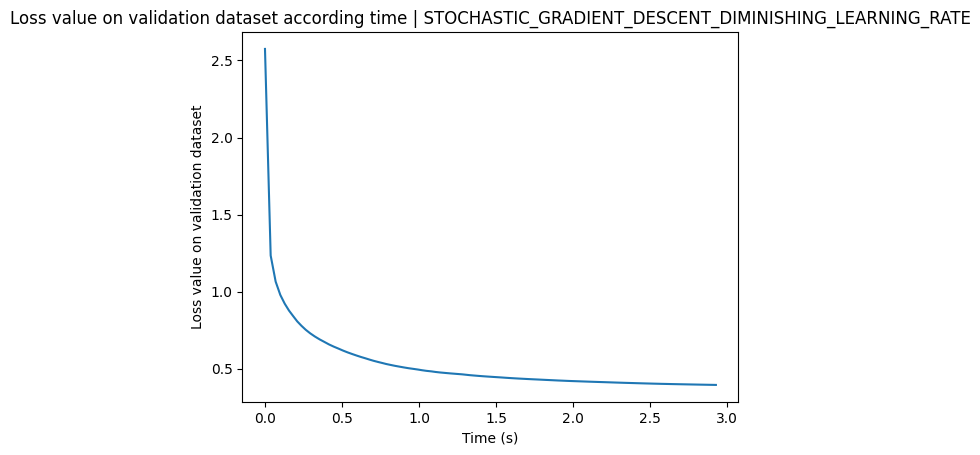

In [25]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_LEARNING_RATE = 0.5
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

RULE = 1  # cyclic

BATCH_SIZE = 1
RANDOM_SEED = 10


for BATCH_SIZE in [16, 32, 64]:
    # ADDITIONAL PARAMETERS
    ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

    ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
    ADDITIONAL_PARAMETERS["rule"] = RULE
    ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

    # for INITIAL_LEARNING_RATE in [0.001,0.01,0.1,0.5]:
    for MAX_EPOCHS in [100]:
        result = main_optimizer.stochastic_gradient_descent_diminishing_learning_rate(
            INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

## 6.10. STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE - randomized

Parameters
Algorithm type: STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
Initial learning rate: 3
Max epochs: 300
Additional parameters: {'batch_size': 50, 'rule': 0, 'random_seed': 10, 'alpha': 0.15, 'beta': 0.9}
Result
Best loss value: 0.628309
Epoch count: 300/300
Best F1 on validation set: 0.555143
Runtime: 20.486901 s


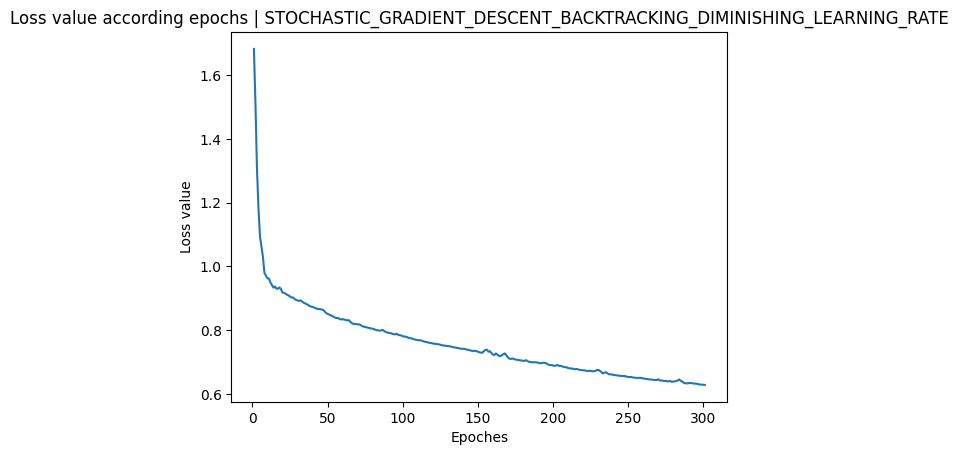

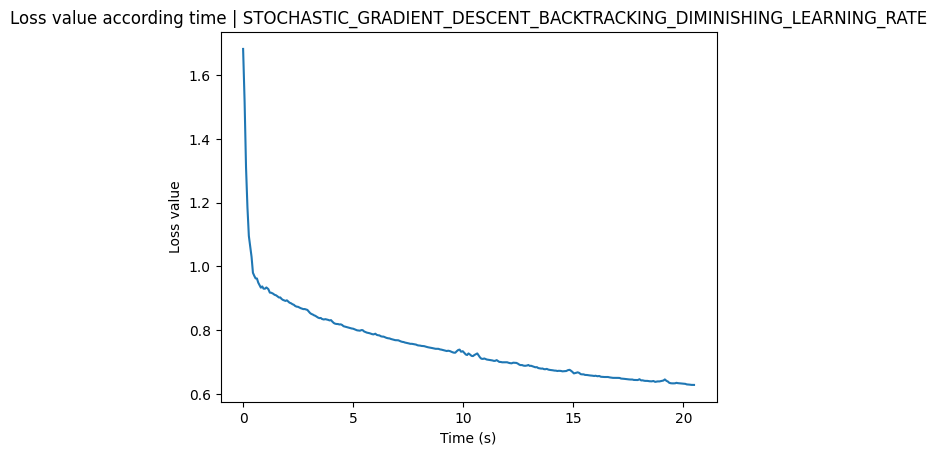

In [886]:
ALGORITHM_TYPE = (
    AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
)
INITIAL_LEARNING_RATE = 3
MAX_EPOCHS = 1100  # SHOULD OVER 1000

RULE = 0  # randomized

BATCH_SIZE = 50
RANDOM_SEED = 10
ALPHA = 0.15
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = (
    main_optimizer.stochastic_gradient_descent_backtracking_diminishing_learning_rate(
        INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
    )
)

result_set.add_result(result)

visualizer.summarize_a_result(result)

## TEST

In [ ]:
ALGORITHM_TYPE = (
    AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
)
# INITIAL_LEARNING_RATE = 3
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

RULE = 0  # randomized

BATCH_SIZE = 50
RANDOM_SEED = 10
ALPHA = 0.15
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

for INITIAL_LEARNING_RATE in [0.3]:
    for MAX_EPOCHS in [300]:
        result = (
            main_optimizer.stochastic_gradient_descent_backtracking_diminishing_learning_rate(
                INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
            )
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

## 6.11. STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE - cyclic

Parameters
Algorithm type: STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Initial learning rate: 3
Max epochs: 300
Additional parameters: {'batch_size': 50, 'rule': 1, 'random_seed': 10, 'alpha': 0.15, 'beta': 0.9}
Result
Best loss value: 0.866747
Epoch count: 300/300
Best F1 on validation set: 0.587384
Runtime: 17.577734 s


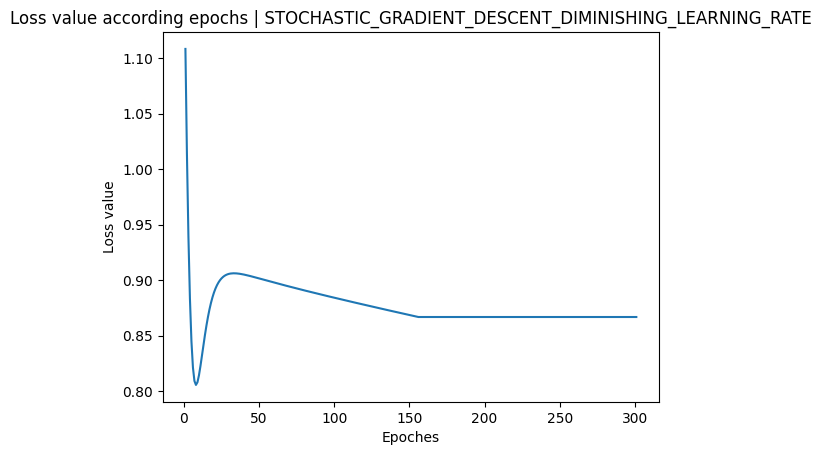

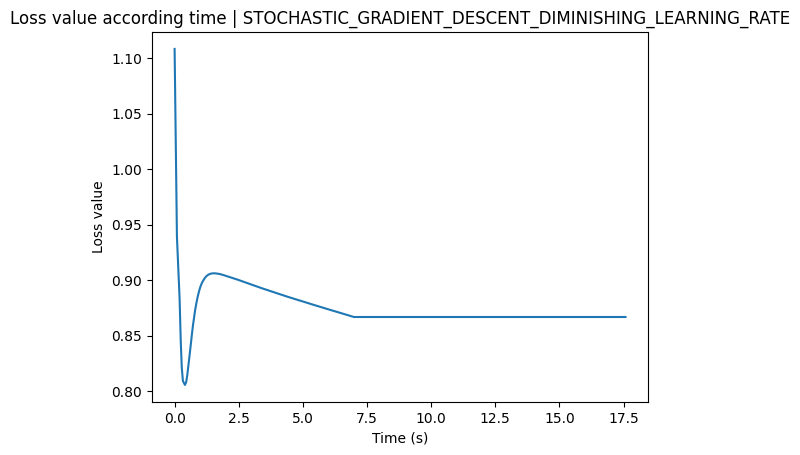

In [887]:
ALGORITHM_TYPE = (
    AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
)
INITIAL_LEARNING_RATE = 3
MAX_EPOCHS = 1100  # SHOULD OVER 1000

RULE = 1  # cyclic

BATCH_SIZE = 50
RANDOM_SEED = 10
ALPHA = 0.15
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = (
    main_optimizer.stochastic_gradient_descent_backtracking_diminishing_learning_rate(
        INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
    )
)

result_set.add_result(result)

visualizer.summarize_a_result(result)

## TEST

In [ ]:
ALGORITHM_TYPE = (
    AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
)
# INITIAL_LEARNING_RATE = 3
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

RULE = 1  # cyclic

BATCH_SIZE = 50
RANDOM_SEED = 10
ALPHA = 0.15
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

for INITIAL_LEARNING_RATE in [0.3]:
    for MAX_EPOCHS in [300]:
        result = (
            main_optimizer.stochastic_gradient_descent_backtracking_diminishing_learning_rate(
                INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
            )
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

## 6.12. MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE

Parameters
Algorithm type: MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
Initial learning rate: 1
Max epochs: 300
Additional parameters: {'gamma': 0.9}
Result
Best loss value: 0.192784
Epoch count: 300/300
Best F1 on validation set: 0.912189
Runtime: 1.844577 s


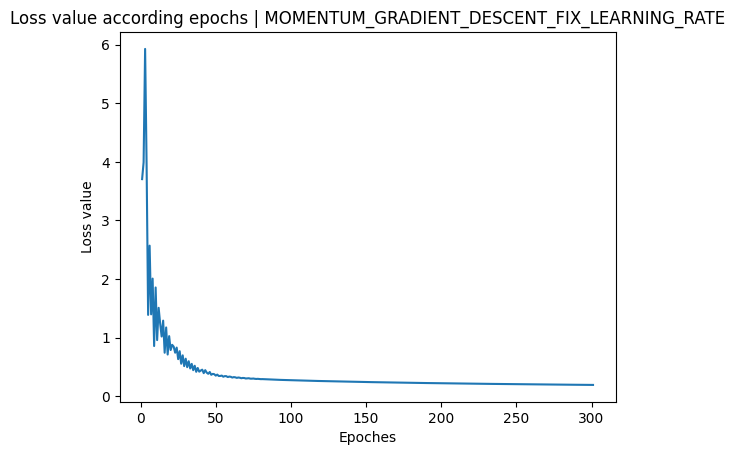

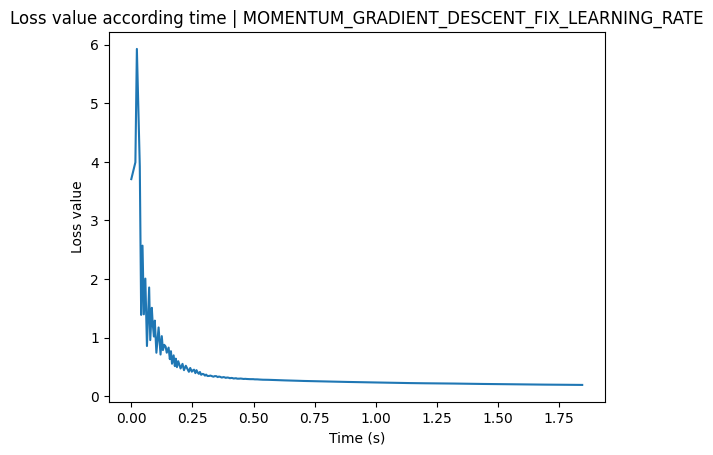

In [888]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 1100  # SHOULD OVER 1000

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA

result = (
    main_optimizer.momentum_gradient_descent_fix_learning_rate(
        INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
    )
)

result_set.add_result(result)

visualizer.summarize_a_result(result)

## TEST

In [ ]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
# INITIAL_LEARNING_RATE = 1
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA

for INITIAL_LEARNING_RATE in [0.3]:
    for MAX_EPOCHS in [300]:
        result = (
            main_optimizer.momentum_gradient_descent_fix_learning_rate(
                INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
            )
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

## 6.13. MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

Parameters
Algorithm type: MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Initial learning rate: 1
Max epochs: 300
Additional parameters: {'gamma': 0.9, 'alpha': 0.1, 'beta': 0.9}
Result
Best loss value: 0.399359
Epoch count: 59/300
Best F1 on validation set: 0.727031
Runtime: 332.325659 s


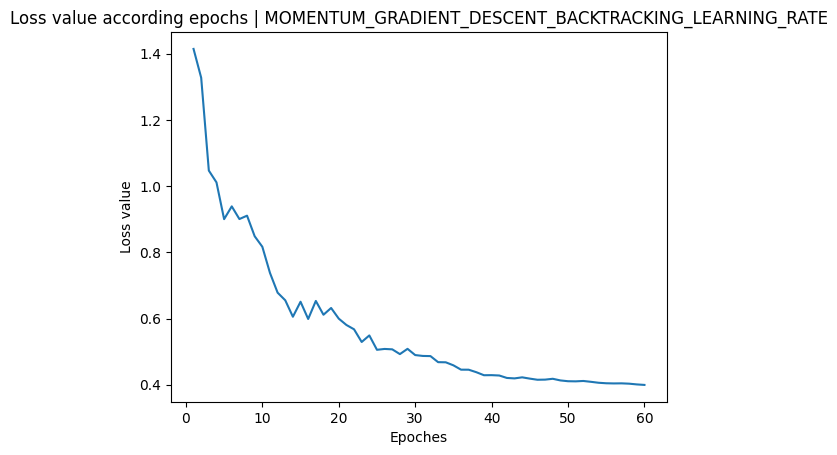

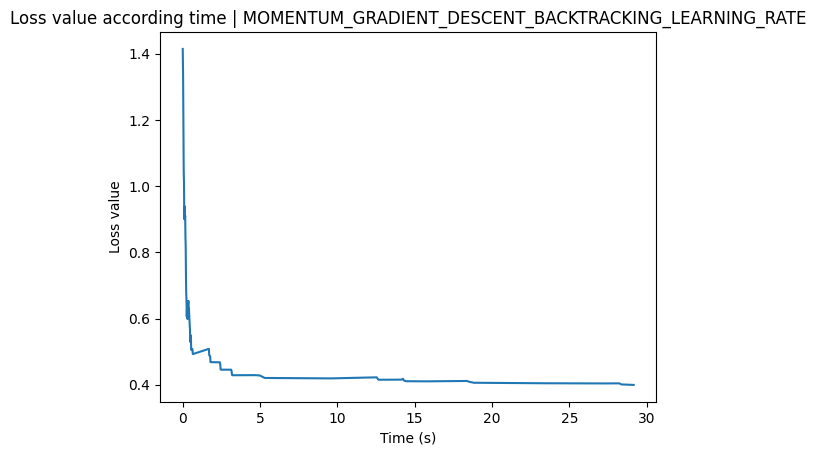

In [889]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 1100  # SHOULD OVER 1000

GAMMA = 0.9
ALPHA = 0.1
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA


result = main_optimizer.momentum_gradient_descent_backtracking_learning_rate(
    INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
)

result_set.add_result(result)

visualizer.summarize_a_result(result)

## TEST

In [ ]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
# INITIAL_LEARNING_RATE = 1
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

GAMMA = 0.9
ALPHA = 0.1
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

for INITIAL_LEARNING_RATE in [0.3]:
    for MAX_EPOCHS in [300]:
        result = main_optimizer.momentum_gradient_descent_backtracking_learning_rate(
            INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

## 6.14. NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE

Parameters
Algorithm type: NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Initial learning rate: 0.5
Max epochs: 300
Additional parameters: {'NAG_gamma': 0.9}
Result
Best loss value: 0.248677
Epoch count: 300/300
Best F1 on validation set: 0.852547
Runtime: 1.992569 s


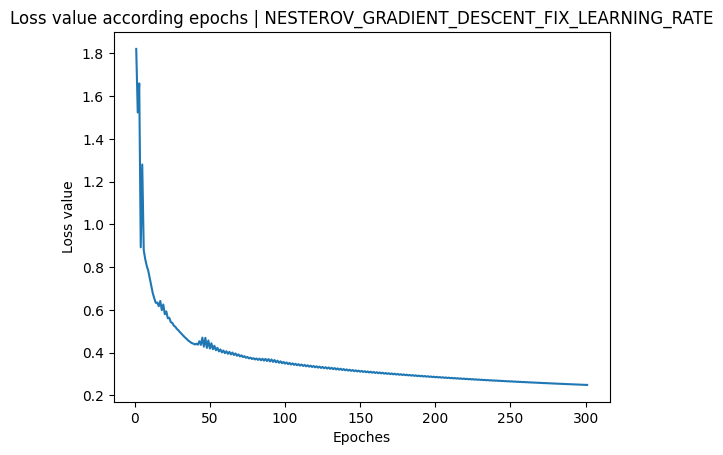

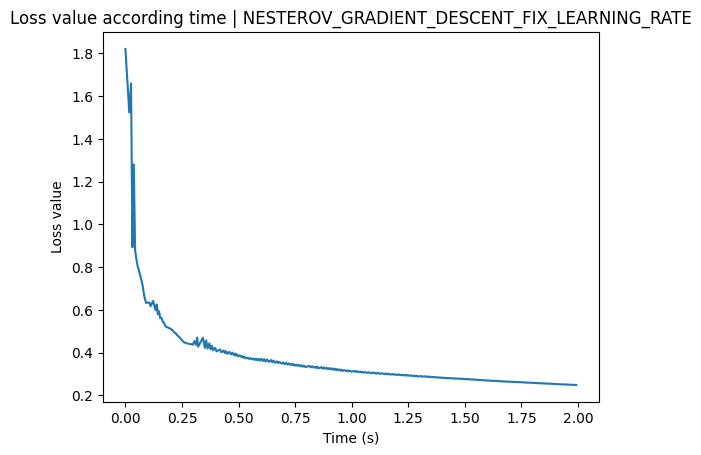

In [890]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 1100  # SHOULD OVER 1000

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA

result = main_optimizer.nesterov_gradient_descent_fix_learning_rate(
    INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
)

result_set.add_result(result)

visualizer.summarize_a_result(result)

## TEST

In [ ]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
# INITIAL_LEARNING_RATE = 0.5
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA

for INITIAL_LEARNING_RATE in [0.3]:
    for MAX_EPOCHS in [300]:
        result = main_optimizer.nesterov_gradient_descent_fix_learning_rate(
            INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

## 6.15. NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

Parameters
Algorithm type: NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Initial learning rate: 0.5
Max epochs: 300
Additional parameters: {'NAG_gamma': 0.8, 'alpha': 0.15, 'beta': 0.8}
Result
Best loss value: 0.657663
Epoch count: 18/300
Best F1 on validation set: 0.616352
Runtime: 148.494817 s


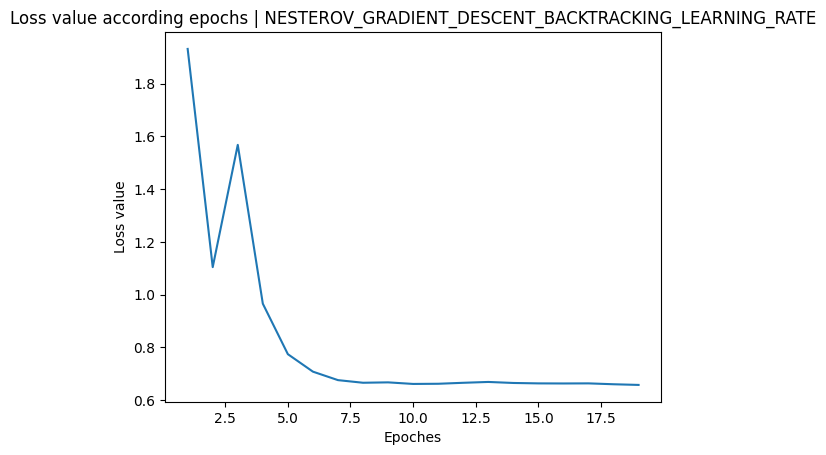

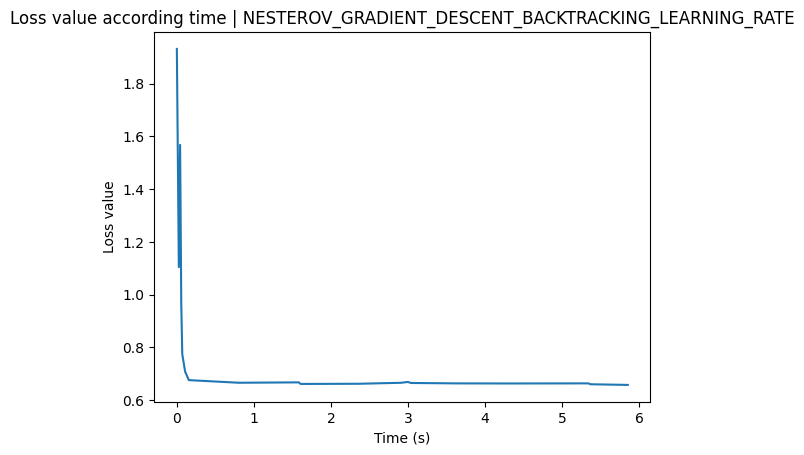

In [891]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 1100  # SHOULD OVER 1000

GAMMA = 0.8
ALPHA = 0.15
BETA = 0.8

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = (
    main_optimizer.nesterov_gradient_descent_backtracking_learning_rate(
        INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
    )
)

result_set.add_result(result)

visualizer.summarize_a_result(result)

## TEST

In [ ]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
# INITIAL_LEARNING_RATE = 0.5
# MAX_EPOCHS = 1100  # SHOULD OVER 1000

GAMMA = 0.8
ALPHA = 0.15
BETA = 0.8

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

for INITIAL_LEARNING_RATE in [0.3]:
    for MAX_EPOCHS in [300]:
        result = main_optimizer.nesterov_gradient_descent_backtracking_learning_rate(
            INITIAL_LEARNING_RATE, MAX_EPOCHS, ADDITIONAL_PARAMETERS
        )

        result_set.add_result(result)

        visualizer.summarize_a_result(result)

## 6.16. NEWTON

Parameters
Algorithm type: NEWTON
Max epochs: 5
Additional parameters: {'test': 1}
Result
Best loss value on validation dataset at epoch 2: 0.145228
Epoch count: 2/5
Best F1 on validation dataset at epoch 2: 0.958549
Runtime: 0.872705 s


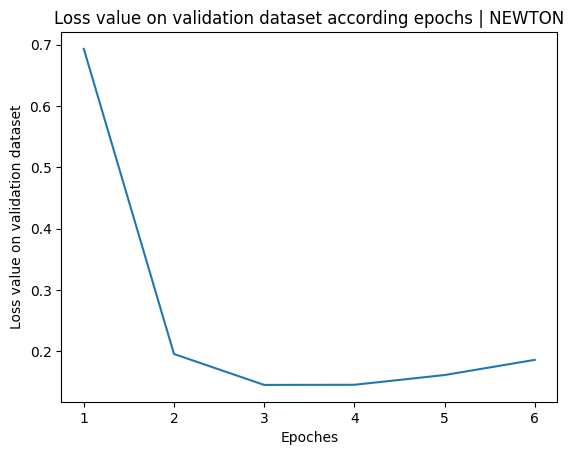

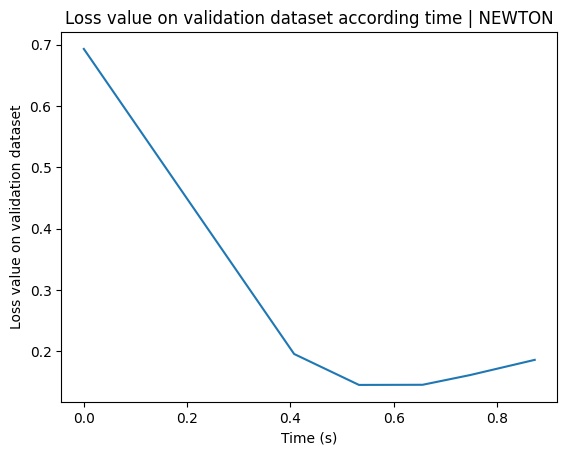

In [202]:
ALGORITHM_TYPE = AlgorithmType.NEWTON
MAX_EPOCHS = 5  # SHOULD OVER 1000

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

result = main_optimizer.newton(MAX_EPOCHS, ADDITIONAL_PARAMETERS)

result_set.add_result(result)

visualizer.summarize_a_result(result)

# 7. Save and load ResultSets

### 7.1. Save data

In [203]:
result_set.output_to_json("result_set")

### 7.2. Load data

In [878]:
loaded_list_result = result_set.load_result_from_json_in_folder("result")

Loaded 3 results in all .json files


# 8. Filter and visualize results

## 8.1. Filter all best GRADIENT_DESCENT_FIX_LEARNING_RATE algorithms

In [1026]:
# Specify algorithm_type to filter all result with that algorithm_type

best_GRADIENT_DESCENT_FIX_LEARNING_RATE = result_set.filter_best_loss_value_result(
    list_result=loaded_list_result,
    number_of_result=3,
    algorithm_type=AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE,
)

Filtered and get 2 results


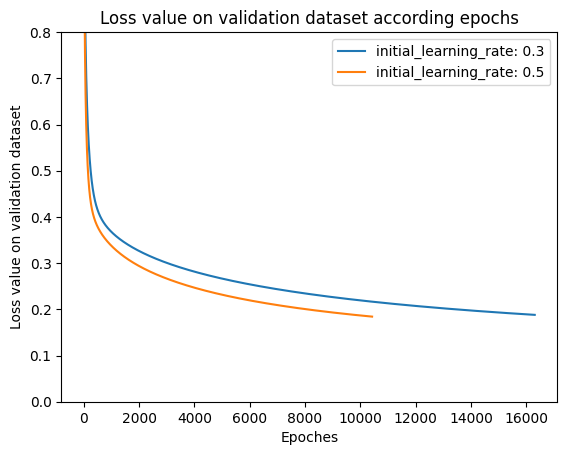

In [1027]:
visualizer.plot_multiple_graph(
    list_result=best_GRADIENT_DESCENT_FIX_LEARNING_RATE,
    label="initial_learning_rate",
    y_range=[0, 0.8],
)

## 8.x. Filter all best algorithms

In [1028]:
# If select all best of each algorithm, don't need to specify algorithm_type
# number_of_result = 5 means select top 5 algorithms

best_of_all = result_set.filter_best_loss_value_result(
    list_result=loaded_list_result, number_of_result=5
)

Filtered and get 2 results


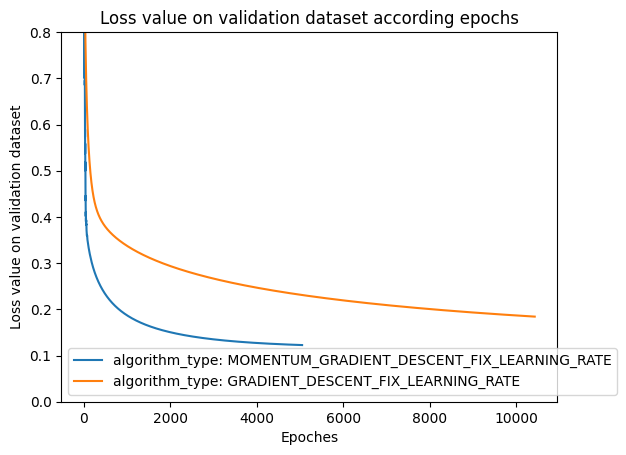

In [1029]:
visualizer.plot_multiple_graph(best_of_all, "algorithm_type", y_range=[0, 0.8])